<a href="https://colab.research.google.com/github/Saurav2910/My-Deeplearning-Projects/blob/main/H2S_ANN_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving Unit2800Data_hourly.csv to Unit2800Data_hourly (2).csv


In [2]:
import os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [3]:
# ---------- reproducibility ----------
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [4]:
FILE_PATH = "Unit2800Data_hourly.csv"
TARGET = "2800AI050.PV"
TEST_SIZE = 0.15   # final test split
VAL_SIZE = 0.15    # validation split (of full dataset); we'll perform split in two steps
MAX_EPOCHS = 80
BATCH_SIZE = 32
PATIENCE = 30      # early stopping patience
RESULTS_DIR = "ann_results"
os.makedirs(RESULTS_DIR, exist_ok=True)

In [5]:
# ---------- load data ----------
df = pd.read_csv(FILE_PATH)

In [6]:
# If Timestamp present
if "Timestamp" in df.columns:
    df = df.drop(columns=["Timestamp"])

In [7]:
# drop rows with missing target
df = df.dropna(subset=[TARGET]).reset_index(drop=True)

In [8]:
# ---------- domain driven features
# delta temps
if all(c in df.columns for c in ["2800TC025.PV","2800TI020.PV"]):
    df["delta_reboiler_feed_minus_overhead"] = df["2800TC025.PV"] - df["2800TI020.PV"]
if all(c in df.columns for c in ["2800TI024.PV","2800TI020.PV"]):
    df["delta_mdea_outlet_minus_overhead"] = df["2800TI024.PV"] - df["2800TI020.PV"]
if all(c in df.columns for c in ["2800FC041.PV","2800FC051.PV"]):
    df["Refluxflow_to_Feed_ratio_v2"] = df["2800FC041.PV"] / (df["2800FC051.PV"].replace(0, np.nan))


#Adding Rolling and Lag features in Target column

In [9]:
def add_lag_features(data, col, lags=[2,3,6]):
    """Add lag features for target itself"""
    for lag in lags:
        data[f"{col}_lag{lag}"] = data[col].shift(lag)
    return data

def add_rolling_features(data, col, windows=[3, 6, 12]):
    """Add rolling mean and std for target itself"""
    for w in windows:
        data[f"{col}_roll{w}_mean"] = data[col].rolling(w).mean()
        data[f"{col}_roll{w}_std"] = data[col].rolling(w).std()
    return data

In [10]:
# Add lags & rolling features for target itself
df = add_lag_features(df, TARGET)
df = add_rolling_features(df, TARGET)

In [11]:
# simple cleanup: drop any columns that are non-numeric (if any)
df = df.select_dtypes(include=[np.number]).copy()
df = df.dropna().reset_index(drop=True)

In [12]:
df.head()

,2800AI050.PV,2800TI020.PV,2800PDI023.PV,2800TI023.PV,2800FC020.PV,2800TC025.PV,2800TI024.PV,2800TI034.PV,2800FC041.PV,2800FC051.PV,...,Refluxflow_to_Feed_ratio_v2,2800AI050.PV_lag2,2800AI050.PV_lag3,2800AI050.PV_lag6,2800AI050.PV_roll3_mean,2800AI050.PV_roll3_std,2800AI050.PV_roll6_mean,2800AI050.PV_roll6_std,2800AI050.PV_roll12_mean,2800AI050.PV_roll12_std
0,2.721031,98.369832,0.185180,126.586976,6735.290910,145.604179,96.473767,35.926364,0.673705,120.974101,...,0.005569,3.078700,8.687205,6.937534,3.854531,1.663171,4.498046,2.386617,4.956045,1.786454
1,3.759303,98.385250,0.185901,126.802006,6723.144906,145.649127,96.589693,37.610359,0.580765,119.637621,...,0.004854,5.763860,3.078700,2.472810,4.081398,1.546774,4.712462,2.220271,4.881668,1.818563
2,2.132578,98.678824,0.187208,127.360902,6725.027319,145.889635,96.954096,38.727322,0.671406,119.438000,...,0.005621,2.721031,5.763860,4.264670,2.870971,0.823663,4.357113,2.463561,4.571808,1.950403
3,4.085523,98.871090,0.189480,127.859234,6748.483293,146.212931,97.099319,38.908449,0.388530,119.635452,...,0.003248,3.759303,2.721031,8.687205,3.325801,1.046156,3.590166,1.275969,4.453294,1.931482
4,5.350232,98.970288,0.201847,128.607311,7067.088656,146.587251,97.227957,39.717958,0.709725,119.684353,...,0.005930,2.132578,3.759303,3.078700,3.856111,1.621048,3.968755,1.422445,4.526294,1.948821


In [13]:
# ---------- features & target ----------
X = df.drop(columns=[TARGET]).copy()
y = df[TARGET].copy().values.reshape(-1,1)

feature_names = X.columns.tolist()

In [14]:
# ---------- Min-Max scaling (as in the paper) ----------
x_scaler = MinMaxScaler()
X_scaled = x_scaler.fit_transform(X)

y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(y)

In [15]:
# ---------- train/val/test split ----------
# first split off final test
X_temp, X_test, y_temp, y_test = train_test_split(X_scaled, y_scaled, test_size=TEST_SIZE, random_state=SEED, shuffle=True)
# from temp split validation portion
val_fraction_of_temp = VAL_SIZE / (1.0 - TEST_SIZE)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=val_fraction_of_temp, random_state=SEED, shuffle=True)

print("Shapes: ", X_train.shape, X_val.shape, X_test.shape)

Shapes:  (3083, 22) (661, 22) (661, 22)


In [16]:
# ---------- helper: build MLP with tanh hidden, linear output ----------
def build_mlp(input_dim, hidden_layers, dropout_rate=0.0):
    model = Sequential()
    # first hidden layer
    model.add(Dense(hidden_layers[0], input_dim=input_dim, activation='tanh'))
    if dropout_rate>0:
        model.add(Dropout(dropout_rate))
    # remaining hidden layers
    for n in hidden_layers[1:]:
        model.add(Dense(n, activation='tanh'))
        if dropout_rate>0:
            model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
    return model

In [17]:
# ---------- architecture grid ----------
layer_options = [
    [5], [10], [15], [20],   # single-layer small neurons
    [20,10], [30,15], [40,20],  # two-layer
    [40,20,10]  # three-layer
]
dropout_options = [0.0, 0.1]   # small dropout optionally
runs = []

best_val_mse = np.inf
best_model_path = None
best_config = None

In [18]:
# callbacks set (we will create per-model with unique checkpoint path)
for layers in layer_options:
    for dropout_rate in dropout_options:
        config_name = f"layers_{'-'.join(map(str,layers))}_drop_{dropout_rate}"
        print("\nTraining config:", config_name)
        model = build_mlp(input_dim=X_train.shape[1], hidden_layers=layers, dropout_rate=dropout_rate)
        ckpt_path = os.path.join(RESULTS_DIR, f"best_{config_name}.h5")
        es = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True, verbose=1)
        rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
        chk = ModelCheckpoint(ckpt_path, monitor='val_loss', save_best_only=True, verbose=0)
        hist = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=MAX_EPOCHS,
            batch_size=BATCH_SIZE,
            callbacks=[es, rlr, chk],
            verbose=2
        )


Training config: layers_5_drop_0.0
Epoch 1/80


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


97/97 - 2s - 18ms/step - loss: 0.3426 - val_loss: 0.0390 - learning_rate: 1.0000e-03
Epoch 2/80


97/97 - 1s - 6ms/step - loss: 0.0339 - val_loss: 0.0287 - learning_rate: 1.0000e-03
Epoch 3/80


97/97 - 1s - 8ms/step - loss: 0.0252 - val_loss: 0.0227 - learning_rate: 1.0000e-03
Epoch 4/80


97/97 - 1s - 14ms/step - loss: 0.0206 - val_loss: 0.0199 - learning_rate: 1.0000e-03
Epoch 5/80


97/97 - 1s - 5ms/step - loss: 0.0184 - val_loss: 0.0184 - learning_rate: 1.0000e-03
Epoch 6/80


97/97 - 1s - 6ms/step - loss: 0.0171 - val_loss: 0.0175 - learning_rate: 1.0000e-03
Epoch 7/80


97/97 - 1s - 12ms/step - loss: 0.0161 - val_loss: 0.0167 - learning_rate: 1.0000e-03
Epoch 8/80


97/97 - 1s - 6ms/step - loss: 0.0153 - val_loss: 0.0159 - learning_rate: 1.0000e-03
Epoch 9/80


97/97 - 1s - 7ms/step - loss: 0.0146 - val_loss: 0.0151 - learning_rate: 1.0000e-03
Epoch 10/80


97/97 - 1s - 6ms/step - loss: 0.0139 - val_loss: 0.0144 - learning_rate: 1.0000e-03
Epoch 11/80


97/97 - 1s - 6ms/step - loss: 0.0132 - val_loss: 0.0137 - learning_rate: 1.0000e-03
Epoch 12/80


97/97 - 1s - 10ms/step - loss: 0.0125 - val_loss: 0.0131 - learning_rate: 1.0000e-03
Epoch 13/80


97/97 - 1s - 10ms/step - loss: 0.0119 - val_loss: 0.0124 - learning_rate: 1.0000e-03
Epoch 14/80


97/97 - 1s - 12ms/step - loss: 0.0114 - val_loss: 0.0119 - learning_rate: 1.0000e-03
Epoch 15/80


97/97 - 1s - 9ms/step - loss: 0.0108 - val_loss: 0.0113 - learning_rate: 1.0000e-03
Epoch 16/80


97/97 - 1s - 8ms/step - loss: 0.0103 - val_loss: 0.0108 - learning_rate: 1.0000e-03
Epoch 17/80


97/97 - 1s - 6ms/step - loss: 0.0099 - val_loss: 0.0103 - learning_rate: 1.0000e-03
Epoch 18/80


97/97 - 1s - 6ms/step - loss: 0.0094 - val_loss: 0.0099 - learning_rate: 1.0000e-03
Epoch 19/80


97/97 - 0s - 3ms/step - loss: 0.0090 - val_loss: 0.0095 - learning_rate: 1.0000e-03
Epoch 20/80


97/97 - 0s - 3ms/step - loss: 0.0087 - val_loss: 0.0091 - learning_rate: 1.0000e-03
Epoch 21/80


97/97 - 0s - 3ms/step - loss: 0.0083 - val_loss: 0.0087 - learning_rate: 1.0000e-03
Epoch 22/80


97/97 - 0s - 3ms/step - loss: 0.0080 - val_loss: 0.0083 - learning_rate: 1.0000e-03
Epoch 23/80


97/97 - 0s - 3ms/step - loss: 0.0077 - val_loss: 0.0080 - learning_rate: 1.0000e-03
Epoch 24/80


97/97 - 0s - 3ms/step - loss: 0.0073 - val_loss: 0.0076 - learning_rate: 1.0000e-03
Epoch 25/80


97/97 - 0s - 3ms/step - loss: 0.0071 - val_loss: 0.0073 - learning_rate: 1.0000e-03
Epoch 26/80


97/97 - 0s - 3ms/step - loss: 0.0068 - val_loss: 0.0070 - learning_rate: 1.0000e-03
Epoch 27/80


97/97 - 0s - 3ms/step - loss: 0.0065 - val_loss: 0.0068 - learning_rate: 1.0000e-03
Epoch 28/80


97/97 - 0s - 3ms/step - loss: 0.0063 - val_loss: 0.0065 - learning_rate: 1.0000e-03
Epoch 29/80


97/97 - 0s - 3ms/step - loss: 0.0061 - val_loss: 0.0063 - learning_rate: 1.0000e-03
Epoch 30/80


97/97 - 0s - 3ms/step - loss: 0.0059 - val_loss: 0.0061 - learning_rate: 1.0000e-03
Epoch 31/80


97/97 - 0s - 3ms/step - loss: 0.0057 - val_loss: 0.0059 - learning_rate: 1.0000e-03
Epoch 32/80


97/97 - 0s - 3ms/step - loss: 0.0055 - val_loss: 0.0057 - learning_rate: 1.0000e-03
Epoch 33/80


97/97 - 0s - 3ms/step - loss: 0.0053 - val_loss: 0.0055 - learning_rate: 1.0000e-03
Epoch 34/80


97/97 - 0s - 3ms/step - loss: 0.0052 - val_loss: 0.0054 - learning_rate: 1.0000e-03
Epoch 35/80


97/97 - 0s - 3ms/step - loss: 0.0051 - val_loss: 0.0052 - learning_rate: 1.0000e-03
Epoch 36/80


97/97 - 0s - 3ms/step - loss: 0.0050 - val_loss: 0.0051 - learning_rate: 1.0000e-03
Epoch 37/80


97/97 - 0s - 3ms/step - loss: 0.0049 - val_loss: 0.0050 - learning_rate: 1.0000e-03
Epoch 38/80


97/97 - 0s - 3ms/step - loss: 0.0048 - val_loss: 0.0049 - learning_rate: 1.0000e-03
Epoch 39/80


97/97 - 0s - 3ms/step - loss: 0.0047 - val_loss: 0.0048 - learning_rate: 1.0000e-03
Epoch 40/80


97/97 - 0s - 3ms/step - loss: 0.0046 - val_loss: 0.0047 - learning_rate: 1.0000e-03
Epoch 41/80


97/97 - 0s - 3ms/step - loss: 0.0046 - val_loss: 0.0047 - learning_rate: 1.0000e-03
Epoch 42/80


97/97 - 0s - 3ms/step - loss: 0.0045 - val_loss: 0.0046 - learning_rate: 1.0000e-03
Epoch 43/80


97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0046 - learning_rate: 1.0000e-03
Epoch 44/80


97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0045 - learning_rate: 1.0000e-03
Epoch 45/80


97/97 - 0s - 4ms/step - loss: 0.0044 - val_loss: 0.0045 - learning_rate: 1.0000e-03
Epoch 46/80


97/97 - 1s - 7ms/step - loss: 0.0043 - val_loss: 0.0044 - learning_rate: 1.0000e-03
Epoch 47/80


97/97 - 0s - 5ms/step - loss: 0.0043 - val_loss: 0.0044 - learning_rate: 1.0000e-03
Epoch 48/80


97/97 - 0s - 4ms/step - loss: 0.0043 - val_loss: 0.0044 - learning_rate: 1.0000e-03
Epoch 49/80


97/97 - 0s - 5ms/step - loss: 0.0042 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 50/80


97/97 - 0s - 3ms/step - loss: 0.0042 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 51/80


97/97 - 0s - 3ms/step - loss: 0.0042 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 52/80


97/97 - 0s - 3ms/step - loss: 0.0042 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 53/80


97/97 - 0s - 3ms/step - loss: 0.0042 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 54/80


97/97 - 0s - 3ms/step - loss: 0.0041 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 55/80


97/97 - 0s - 3ms/step - loss: 0.0041 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 56/80


97/97 - 0s - 3ms/step - loss: 0.0041 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 57/80


97/97 - 0s - 3ms/step - loss: 0.0041 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 58/80


97/97 - 0s - 3ms/step - loss: 0.0041 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 59/80


97/97 - 0s - 3ms/step - loss: 0.0041 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 60/80


97/97 - 0s - 3ms/step - loss: 0.0041 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 61/80


97/97 - 0s - 3ms/step - loss: 0.0041 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 62/80


97/97 - 0s - 3ms/step - loss: 0.0041 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 63/80


97/97 - 0s - 3ms/step - loss: 0.0041 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 64/80


97/97 - 0s - 3ms/step - loss: 0.0041 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 65/80


97/97 - 0s - 3ms/step - loss: 0.0041 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 66/80


97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 67/80

Epoch 67: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 68/80


97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 69/80


97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 70/80


97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 71/80


97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 72/80


97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 73/80


97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 74/80


97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 75/80


97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 76/80


97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 77/80

Epoch 77: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.


97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 78/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 79/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 80/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Restoring model weights from the end of the best epoch: 77.

Training config: layers_5_drop_0.1
Epoch 1/80


97/97 - 1s - 12ms/step - loss: 0.1872 - val_loss: 0.0585 - learning_rate: 1.0000e-03
Epoch 2/80


97/97 - 0s - 3ms/step - loss: 0.0770 - val_loss: 0.0248 - learning_rate: 1.0000e-03
Epoch 3/80


97/97 - 1s - 5ms/step - loss: 0.0403 - val_loss: 0.0159 - learning_rate: 1.0000e-03
Epoch 4/80


97/97 - 1s - 6ms/step - loss: 0.0241 - val_loss: 0.0115 - learning_rate: 1.0000e-03
Epoch 5/80


97/97 - 1s - 7ms/step - loss: 0.0179 - val_loss: 0.0095 - learning_rate: 1.0000e-03
Epoch 6/80


97/97 - 0s - 5ms/step - loss: 0.0151 - val_loss: 0.0087 - learning_rate: 1.0000e-03
Epoch 7/80


97/97 - 0s - 3ms/step - loss: 0.0144 - val_loss: 0.0079 - learning_rate: 1.0000e-03
Epoch 8/80


97/97 - 0s - 3ms/step - loss: 0.0127 - val_loss: 0.0074 - learning_rate: 1.0000e-03
Epoch 9/80


97/97 - 0s - 3ms/step - loss: 0.0116 - val_loss: 0.0070 - learning_rate: 1.0000e-03
Epoch 10/80


97/97 - 0s - 3ms/step - loss: 0.0108 - val_loss: 0.0067 - learning_rate: 1.0000e-03
Epoch 11/80


97/97 - 0s - 3ms/step - loss: 0.0101 - val_loss: 0.0063 - learning_rate: 1.0000e-03
Epoch 12/80


97/97 - 0s - 3ms/step - loss: 0.0098 - val_loss: 0.0061 - learning_rate: 1.0000e-03
Epoch 13/80


97/97 - 0s - 3ms/step - loss: 0.0090 - val_loss: 0.0059 - learning_rate: 1.0000e-03
Epoch 14/80


97/97 - 0s - 3ms/step - loss: 0.0084 - val_loss: 0.0057 - learning_rate: 1.0000e-03
Epoch 15/80


97/97 - 0s - 3ms/step - loss: 0.0085 - val_loss: 0.0055 - learning_rate: 1.0000e-03
Epoch 16/80
97/97 - 0s - 3ms/step - loss: 0.0077 - val_loss: 0.0055 - learning_rate: 1.0000e-03
Epoch 17/80


97/97 - 0s - 3ms/step - loss: 0.0073 - val_loss: 0.0053 - learning_rate: 1.0000e-03
Epoch 18/80


97/97 - 0s - 3ms/step - loss: 0.0072 - val_loss: 0.0051 - learning_rate: 1.0000e-03
Epoch 19/80


97/97 - 0s - 3ms/step - loss: 0.0070 - val_loss: 0.0050 - learning_rate: 1.0000e-03
Epoch 20/80


97/97 - 0s - 3ms/step - loss: 0.0067 - val_loss: 0.0050 - learning_rate: 1.0000e-03
Epoch 21/80


97/97 - 0s - 3ms/step - loss: 0.0064 - val_loss: 0.0049 - learning_rate: 1.0000e-03
Epoch 22/80


97/97 - 0s - 3ms/step - loss: 0.0064 - val_loss: 0.0048 - learning_rate: 1.0000e-03
Epoch 23/80


97/97 - 0s - 3ms/step - loss: 0.0062 - val_loss: 0.0048 - learning_rate: 1.0000e-03
Epoch 24/80


97/97 - 0s - 3ms/step - loss: 0.0058 - val_loss: 0.0047 - learning_rate: 1.0000e-03
Epoch 25/80


97/97 - 0s - 3ms/step - loss: 0.0057 - val_loss: 0.0046 - learning_rate: 1.0000e-03
Epoch 26/80


97/97 - 0s - 3ms/step - loss: 0.0057 - val_loss: 0.0046 - learning_rate: 1.0000e-03
Epoch 27/80


97/97 - 0s - 3ms/step - loss: 0.0054 - val_loss: 0.0045 - learning_rate: 1.0000e-03
Epoch 28/80


97/97 - 0s - 3ms/step - loss: 0.0054 - val_loss: 0.0045 - learning_rate: 1.0000e-03
Epoch 29/80


97/97 - 0s - 3ms/step - loss: 0.0055 - val_loss: 0.0045 - learning_rate: 1.0000e-03
Epoch 30/80


97/97 - 0s - 5ms/step - loss: 0.0053 - val_loss: 0.0045 - learning_rate: 1.0000e-03
Epoch 31/80


97/97 - 1s - 8ms/step - loss: 0.0052 - val_loss: 0.0044 - learning_rate: 1.0000e-03
Epoch 32/80
97/97 - 1s - 6ms/step - loss: 0.0051 - val_loss: 0.0044 - learning_rate: 1.0000e-03
Epoch 33/80


97/97 - 1s - 9ms/step - loss: 0.0051 - val_loss: 0.0044 - learning_rate: 1.0000e-03
Epoch 34/80


97/97 - 1s - 8ms/step - loss: 0.0050 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 35/80


97/97 - 1s - 13ms/step - loss: 0.0050 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 36/80


97/97 - 1s - 10ms/step - loss: 0.0049 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 37/80


97/97 - 1s - 10ms/step - loss: 0.0050 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 38/80


97/97 - 1s - 13ms/step - loss: 0.0048 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 39/80


97/97 - 1s - 14ms/step - loss: 0.0049 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 40/80
97/97 - 1s - 10ms/step - loss: 0.0048 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 41/80
97/97 - 0s - 4ms/step - loss: 0.0048 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 42/80


97/97 - 0s - 3ms/step - loss: 0.0047 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 43/80
97/97 - 0s - 3ms/step - loss: 0.0047 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 44/80


97/97 - 0s - 3ms/step - loss: 0.0047 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 45/80


97/97 - 0s - 3ms/step - loss: 0.0046 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 46/80
97/97 - 0s - 3ms/step - loss: 0.0046 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 47/80


97/97 - 0s - 3ms/step - loss: 0.0045 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 48/80


97/97 - 0s - 3ms/step - loss: 0.0045 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 49/80


97/97 - 0s - 3ms/step - loss: 0.0046 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 50/80


97/97 - 0s - 3ms/step - loss: 0.0046 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 51/80


97/97 - 0s - 3ms/step - loss: 0.0045 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 52/80

Epoch 52: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 53/80
97/97 - 0s - 3ms/step - loss: 0.0045 - val_loss: 0.0042 - learning_rate: 5.0000e-04
Epoch 54/80
97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0042 - learning_rate: 5.0000e-04
Epoch 55/80
97/97 - 0s - 3ms/step - loss: 0.0045 - val_loss: 0.0042 - learning_rate: 5.0000e-04
Epoch 56/80
97/97 - 0s - 3ms/step - loss: 0.0045 - val_loss: 0.0042 - learning_rate: 5.0000e-04
Epoch 57/80
97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0042 - learning_rate: 5.0000e-04
Epoch 58/80


97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 59/80
97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0042 - learning_rate: 5.0000e-04
Epoch 60/80


97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 61/80
97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0042 - learning_rate: 5.0000e-04
Epoch 62/80

Epoch 62: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
97/97 - 0s - 4ms/step - loss: 0.0045 - val_loss: 0.0042 - learning_rate: 5.0000e-04
Epoch 63/80


97/97 - 0s - 5ms/step - loss: 0.0044 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 64/80
97/97 - 0s - 5ms/step - loss: 0.0044 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 65/80
97/97 - 0s - 4ms/step - loss: 0.0044 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 66/80
97/97 - 0s - 4ms/step - loss: 0.0043 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 67/80
97/97 - 0s - 4ms/step - loss: 0.0043 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 68/80
97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 69/80
97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 70/80
97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 71/80


97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 72/80

Epoch 72: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.


97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 73/80
97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 74/80
97/97 - 0s - 3ms/step - loss: 0.0042 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 75/80
97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 76/80
97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 77/80
97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 78/80
97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 79/80
97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 80/80
97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Restoring model weights from the end of the best epoch: 72.

Training config: layers_10_drop_0.0
Epoch 1/80


97/97 - 1s - 11ms/step - loss: 0.0275 - val_loss: 0.0179 - learning_rate: 1.0000e-03
Epoch 2/80


97/97 - 0s - 3ms/step - loss: 0.0148 - val_loss: 0.0129 - learning_rate: 1.0000e-03
Epoch 3/80


97/97 - 0s - 3ms/step - loss: 0.0109 - val_loss: 0.0101 - learning_rate: 1.0000e-03
Epoch 4/80


97/97 - 0s - 3ms/step - loss: 0.0087 - val_loss: 0.0084 - learning_rate: 1.0000e-03
Epoch 5/80


97/97 - 0s - 3ms/step - loss: 0.0074 - val_loss: 0.0073 - learning_rate: 1.0000e-03
Epoch 6/80


97/97 - 0s - 3ms/step - loss: 0.0065 - val_loss: 0.0066 - learning_rate: 1.0000e-03
Epoch 7/80


97/97 - 0s - 3ms/step - loss: 0.0059 - val_loss: 0.0060 - learning_rate: 1.0000e-03
Epoch 8/80


97/97 - 0s - 3ms/step - loss: 0.0055 - val_loss: 0.0056 - learning_rate: 1.0000e-03
Epoch 9/80


97/97 - 0s - 3ms/step - loss: 0.0052 - val_loss: 0.0053 - learning_rate: 1.0000e-03
Epoch 10/80


97/97 - 0s - 3ms/step - loss: 0.0050 - val_loss: 0.0051 - learning_rate: 1.0000e-03
Epoch 11/80


97/97 - 0s - 3ms/step - loss: 0.0048 - val_loss: 0.0049 - learning_rate: 1.0000e-03
Epoch 12/80


97/97 - 0s - 3ms/step - loss: 0.0046 - val_loss: 0.0048 - learning_rate: 1.0000e-03
Epoch 13/80


97/97 - 0s - 3ms/step - loss: 0.0045 - val_loss: 0.0047 - learning_rate: 1.0000e-03
Epoch 14/80


97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0046 - learning_rate: 1.0000e-03
Epoch 15/80


97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0045 - learning_rate: 1.0000e-03
Epoch 16/80


97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0044 - learning_rate: 1.0000e-03
Epoch 17/80


97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0044 - learning_rate: 1.0000e-03
Epoch 18/80


97/97 - 0s - 3ms/step - loss: 0.0042 - val_loss: 0.0044 - learning_rate: 1.0000e-03
Epoch 19/80


97/97 - 0s - 3ms/step - loss: 0.0042 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 20/80


97/97 - 0s - 4ms/step - loss: 0.0042 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 21/80


97/97 - 1s - 6ms/step - loss: 0.0042 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 22/80


97/97 - 1s - 7ms/step - loss: 0.0041 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 23/80


97/97 - 1s - 7ms/step - loss: 0.0041 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 24/80


97/97 - 0s - 5ms/step - loss: 0.0041 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 25/80


97/97 - 0s - 3ms/step - loss: 0.0041 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 26/80


97/97 - 0s - 3ms/step - loss: 0.0041 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 27/80


97/97 - 0s - 3ms/step - loss: 0.0041 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 28/80
97/97 - 0s - 3ms/step - loss: 0.0041 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 29/80
97/97 - 0s - 3ms/step - loss: 0.0041 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 30/80
97/97 - 0s - 3ms/step - loss: 0.0041 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 31/80

Epoch 31: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
97/97 - 0s - 3ms/step - loss: 0.0041 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 32/80


97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0042 - learning_rate: 5.0000e-04
Epoch 33/80


97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0042 - learning_rate: 5.0000e-04
Epoch 34/80


97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0042 - learning_rate: 5.0000e-04
Epoch 35/80


97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0042 - learning_rate: 5.0000e-04
Epoch 36/80


97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0042 - learning_rate: 5.0000e-04
Epoch 37/80


97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0042 - learning_rate: 5.0000e-04
Epoch 38/80


97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0042 - learning_rate: 5.0000e-04
Epoch 39/80


97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0042 - learning_rate: 5.0000e-04
Epoch 40/80


97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0042 - learning_rate: 5.0000e-04
Epoch 41/80


97/97 - 1s - 7ms/step - loss: 0.0040 - val_loss: 0.0042 - learning_rate: 5.0000e-04
Epoch 42/80

Epoch 42: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.


97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0042 - learning_rate: 5.0000e-04
Epoch 43/80
97/97 - 1s - 6ms/step - loss: 0.0040 - val_loss: 0.0042 - learning_rate: 2.5000e-04
Epoch 44/80
97/97 - 0s - 4ms/step - loss: 0.0040 - val_loss: 0.0042 - learning_rate: 2.5000e-04
Epoch 45/80
97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0042 - learning_rate: 2.5000e-04
Epoch 46/80
97/97 - 1s - 6ms/step - loss: 0.0040 - val_loss: 0.0042 - learning_rate: 2.5000e-04
Epoch 47/80
97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0042 - learning_rate: 2.5000e-04
Epoch 48/80
97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0042 - learning_rate: 2.5000e-04
Epoch 49/80
97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0042 - learning_rate: 2.5000e-04
Epoch 50/80
97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0042 - learning_rate: 2.5000e-04
Epoch 51/80
97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0042 - learning_rate: 2.5000e-04
Epoch 52/80

Epoch 52: ReduceLROnPlateau reducing le

97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0042 - learning_rate: 1.2500e-04
Epoch 54/80


97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0042 - learning_rate: 1.2500e-04
Epoch 55/80


97/97 - 0s - 4ms/step - loss: 0.0039 - val_loss: 0.0042 - learning_rate: 1.2500e-04
Epoch 56/80


97/97 - 0s - 5ms/step - loss: 0.0039 - val_loss: 0.0042 - learning_rate: 1.2500e-04
Epoch 57/80


97/97 - 1s - 7ms/step - loss: 0.0039 - val_loss: 0.0042 - learning_rate: 1.2500e-04
Epoch 58/80


97/97 - 1s - 5ms/step - loss: 0.0039 - val_loss: 0.0042 - learning_rate: 1.2500e-04
Epoch 59/80


97/97 - 1s - 5ms/step - loss: 0.0039 - val_loss: 0.0042 - learning_rate: 1.2500e-04
Epoch 60/80


97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0042 - learning_rate: 1.2500e-04
Epoch 61/80


97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0042 - learning_rate: 1.2500e-04
Epoch 62/80

Epoch 62: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.


97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0042 - learning_rate: 1.2500e-04
Epoch 63/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0042 - learning_rate: 6.2500e-05
Epoch 64/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0042 - learning_rate: 6.2500e-05
Epoch 65/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0042 - learning_rate: 6.2500e-05
Epoch 66/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0042 - learning_rate: 6.2500e-05
Epoch 67/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0042 - learning_rate: 6.2500e-05
Epoch 68/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0042 - learning_rate: 6.2500e-05
Epoch 69/80


97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0042 - learning_rate: 6.2500e-05
Epoch 70/80


97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0042 - learning_rate: 6.2500e-05
Epoch 71/80


97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0042 - learning_rate: 6.2500e-05
Epoch 72/80

Epoch 72: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.


97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0042 - learning_rate: 6.2500e-05
Epoch 73/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0042 - learning_rate: 3.1250e-05
Epoch 74/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0042 - learning_rate: 3.1250e-05
Epoch 75/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0042 - learning_rate: 3.1250e-05
Epoch 76/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0042 - learning_rate: 3.1250e-05
Epoch 77/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0042 - learning_rate: 3.1250e-05
Epoch 78/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0042 - learning_rate: 3.1250e-05
Epoch 79/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0042 - learning_rate: 3.1250e-05
Epoch 80/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0042 - learning_rate: 3.1250e-05
Restoring model weights from the end of the best epoch: 72.

Training config: layers_10_drop_0.1
Epoch 1/80


97/97 - 1s - 12ms/step - loss: 0.0566 - val_loss: 0.0196 - learning_rate: 1.0000e-03
Epoch 2/80


97/97 - 0s - 3ms/step - loss: 0.0207 - val_loss: 0.0108 - learning_rate: 1.0000e-03
Epoch 3/80


97/97 - 0s - 3ms/step - loss: 0.0137 - val_loss: 0.0092 - learning_rate: 1.0000e-03
Epoch 4/80


97/97 - 0s - 3ms/step - loss: 0.0110 - val_loss: 0.0082 - learning_rate: 1.0000e-03
Epoch 5/80


97/97 - 0s - 3ms/step - loss: 0.0092 - val_loss: 0.0075 - learning_rate: 1.0000e-03
Epoch 6/80


97/97 - 0s - 3ms/step - loss: 0.0086 - val_loss: 0.0070 - learning_rate: 1.0000e-03
Epoch 7/80


97/97 - 0s - 3ms/step - loss: 0.0077 - val_loss: 0.0065 - learning_rate: 1.0000e-03
Epoch 8/80


97/97 - 0s - 3ms/step - loss: 0.0073 - val_loss: 0.0062 - learning_rate: 1.0000e-03
Epoch 9/80


97/97 - 0s - 3ms/step - loss: 0.0068 - val_loss: 0.0060 - learning_rate: 1.0000e-03
Epoch 10/80


97/97 - 0s - 3ms/step - loss: 0.0064 - val_loss: 0.0057 - learning_rate: 1.0000e-03
Epoch 11/80


97/97 - 0s - 3ms/step - loss: 0.0065 - val_loss: 0.0055 - learning_rate: 1.0000e-03
Epoch 12/80


97/97 - 0s - 4ms/step - loss: 0.0061 - val_loss: 0.0053 - learning_rate: 1.0000e-03
Epoch 13/80


97/97 - 0s - 5ms/step - loss: 0.0062 - val_loss: 0.0052 - learning_rate: 1.0000e-03
Epoch 14/80


97/97 - 1s - 5ms/step - loss: 0.0059 - val_loss: 0.0050 - learning_rate: 1.0000e-03
Epoch 15/80


97/97 - 1s - 6ms/step - loss: 0.0057 - val_loss: 0.0049 - learning_rate: 1.0000e-03
Epoch 16/80


97/97 - 1s - 6ms/step - loss: 0.0057 - val_loss: 0.0048 - learning_rate: 1.0000e-03
Epoch 17/80


97/97 - 0s - 4ms/step - loss: 0.0054 - val_loss: 0.0048 - learning_rate: 1.0000e-03
Epoch 18/80


97/97 - 0s - 3ms/step - loss: 0.0053 - val_loss: 0.0047 - learning_rate: 1.0000e-03
Epoch 19/80


97/97 - 0s - 3ms/step - loss: 0.0051 - val_loss: 0.0046 - learning_rate: 1.0000e-03
Epoch 20/80


97/97 - 0s - 3ms/step - loss: 0.0050 - val_loss: 0.0045 - learning_rate: 1.0000e-03
Epoch 21/80


97/97 - 0s - 3ms/step - loss: 0.0050 - val_loss: 0.0044 - learning_rate: 1.0000e-03
Epoch 22/80


97/97 - 0s - 3ms/step - loss: 0.0048 - val_loss: 0.0044 - learning_rate: 1.0000e-03
Epoch 23/80


97/97 - 0s - 3ms/step - loss: 0.0048 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 24/80
97/97 - 0s - 3ms/step - loss: 0.0049 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 25/80


97/97 - 0s - 3ms/step - loss: 0.0048 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 26/80


97/97 - 0s - 3ms/step - loss: 0.0047 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 27/80


97/97 - 0s - 3ms/step - loss: 0.0046 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 28/80


97/97 - 0s - 3ms/step - loss: 0.0046 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 29/80


97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 30/80


97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 31/80


97/97 - 0s - 3ms/step - loss: 0.0045 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 32/80


97/97 - 0s - 3ms/step - loss: 0.0045 - val_loss: 0.0041 - learning_rate: 1.0000e-03
Epoch 33/80
97/97 - 0s - 3ms/step - loss: 0.0045 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 34/80


97/97 - 0s - 3ms/step - loss: 0.0045 - val_loss: 0.0041 - learning_rate: 1.0000e-03
Epoch 35/80
97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0041 - learning_rate: 1.0000e-03
Epoch 36/80
97/97 - 0s - 3ms/step - loss: 0.0045 - val_loss: 0.0041 - learning_rate: 1.0000e-03
Epoch 37/80

Epoch 37: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
97/97 - 0s - 3ms/step - loss: 0.0045 - val_loss: 0.0041 - learning_rate: 1.0000e-03
Epoch 38/80
97/97 - 0s - 3ms/step - loss: 0.0045 - val_loss: 0.0042 - learning_rate: 5.0000e-04
Epoch 39/80
97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0042 - learning_rate: 5.0000e-04
Epoch 40/80
97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0042 - learning_rate: 5.0000e-04
Epoch 41/80
97/97 - 0s - 3ms/step - loss: 0.0045 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 42/80


97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 43/80
97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 44/80
97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 45/80


97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 46/80
97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 47/80

Epoch 47: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 48/80


97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 49/80


97/97 - 0s - 3ms/step - loss: 0.0042 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 50/80
97/97 - 0s - 3ms/step - loss: 0.0042 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 51/80
97/97 - 0s - 4ms/step - loss: 0.0042 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 52/80
97/97 - 0s - 5ms/step - loss: 0.0043 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 53/80


97/97 - 0s - 5ms/step - loss: 0.0043 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 54/80


97/97 - 0s - 4ms/step - loss: 0.0042 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 55/80
97/97 - 0s - 4ms/step - loss: 0.0042 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 56/80
97/97 - 0s - 5ms/step - loss: 0.0043 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 57/80
97/97 - 0s - 3ms/step - loss: 0.0042 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 58/80

Epoch 58: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.


97/97 - 0s - 3ms/step - loss: 0.0041 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 59/80
97/97 - 0s - 3ms/step - loss: 0.0042 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 60/80
97/97 - 0s - 3ms/step - loss: 0.0042 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 61/80
97/97 - 0s - 3ms/step - loss: 0.0042 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 62/80
97/97 - 0s - 3ms/step - loss: 0.0042 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 63/80
97/97 - 0s - 3ms/step - loss: 0.0042 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 64/80
97/97 - 0s - 3ms/step - loss: 0.0042 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 65/80
97/97 - 0s - 3ms/step - loss: 0.0042 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 66/80
97/97 - 0s - 3ms/step - loss: 0.0042 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 67/80
97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 68/80

Epoch 68: ReduceLROnPlateau reducing le

97/97 - 1s - 11ms/step - loss: 0.4072 - val_loss: 0.0580 - learning_rate: 1.0000e-03
Epoch 2/80


97/97 - 0s - 3ms/step - loss: 0.0429 - val_loss: 0.0364 - learning_rate: 1.0000e-03
Epoch 3/80


97/97 - 0s - 3ms/step - loss: 0.0279 - val_loss: 0.0245 - learning_rate: 1.0000e-03
Epoch 4/80


97/97 - 0s - 3ms/step - loss: 0.0198 - val_loss: 0.0181 - learning_rate: 1.0000e-03
Epoch 5/80


97/97 - 0s - 3ms/step - loss: 0.0153 - val_loss: 0.0144 - learning_rate: 1.0000e-03
Epoch 6/80


97/97 - 0s - 3ms/step - loss: 0.0125 - val_loss: 0.0122 - learning_rate: 1.0000e-03
Epoch 7/80


97/97 - 0s - 3ms/step - loss: 0.0108 - val_loss: 0.0108 - learning_rate: 1.0000e-03
Epoch 8/80


97/97 - 0s - 3ms/step - loss: 0.0096 - val_loss: 0.0097 - learning_rate: 1.0000e-03
Epoch 9/80


97/97 - 0s - 4ms/step - loss: 0.0087 - val_loss: 0.0090 - learning_rate: 1.0000e-03
Epoch 10/80


97/97 - 0s - 4ms/step - loss: 0.0081 - val_loss: 0.0084 - learning_rate: 1.0000e-03
Epoch 11/80


97/97 - 1s - 7ms/step - loss: 0.0076 - val_loss: 0.0079 - learning_rate: 1.0000e-03
Epoch 12/80


97/97 - 0s - 4ms/step - loss: 0.0072 - val_loss: 0.0075 - learning_rate: 1.0000e-03
Epoch 13/80


97/97 - 0s - 5ms/step - loss: 0.0068 - val_loss: 0.0071 - learning_rate: 1.0000e-03
Epoch 14/80


97/97 - 0s - 5ms/step - loss: 0.0065 - val_loss: 0.0068 - learning_rate: 1.0000e-03
Epoch 15/80


97/97 - 0s - 3ms/step - loss: 0.0063 - val_loss: 0.0066 - learning_rate: 1.0000e-03
Epoch 16/80


97/97 - 0s - 3ms/step - loss: 0.0060 - val_loss: 0.0063 - learning_rate: 1.0000e-03
Epoch 17/80


97/97 - 0s - 3ms/step - loss: 0.0058 - val_loss: 0.0061 - learning_rate: 1.0000e-03
Epoch 18/80


97/97 - 0s - 3ms/step - loss: 0.0057 - val_loss: 0.0059 - learning_rate: 1.0000e-03
Epoch 19/80


97/97 - 0s - 3ms/step - loss: 0.0055 - val_loss: 0.0058 - learning_rate: 1.0000e-03
Epoch 20/80


97/97 - 0s - 3ms/step - loss: 0.0054 - val_loss: 0.0056 - learning_rate: 1.0000e-03
Epoch 21/80


97/97 - 0s - 3ms/step - loss: 0.0052 - val_loss: 0.0055 - learning_rate: 1.0000e-03
Epoch 22/80


97/97 - 0s - 3ms/step - loss: 0.0051 - val_loss: 0.0053 - learning_rate: 1.0000e-03
Epoch 23/80


97/97 - 1s - 5ms/step - loss: 0.0050 - val_loss: 0.0052 - learning_rate: 1.0000e-03
Epoch 24/80


97/97 - 0s - 3ms/step - loss: 0.0049 - val_loss: 0.0051 - learning_rate: 1.0000e-03
Epoch 25/80


97/97 - 1s - 6ms/step - loss: 0.0048 - val_loss: 0.0050 - learning_rate: 1.0000e-03
Epoch 26/80


97/97 - 0s - 4ms/step - loss: 0.0047 - val_loss: 0.0049 - learning_rate: 1.0000e-03
Epoch 27/80


97/97 - 1s - 5ms/step - loss: 0.0046 - val_loss: 0.0048 - learning_rate: 1.0000e-03
Epoch 28/80


97/97 - 0s - 3ms/step - loss: 0.0045 - val_loss: 0.0048 - learning_rate: 1.0000e-03
Epoch 29/80


97/97 - 0s - 3ms/step - loss: 0.0045 - val_loss: 0.0047 - learning_rate: 1.0000e-03
Epoch 30/80


97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0046 - learning_rate: 1.0000e-03
Epoch 31/80


97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0046 - learning_rate: 1.0000e-03
Epoch 32/80


97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0045 - learning_rate: 1.0000e-03
Epoch 33/80


97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0045 - learning_rate: 1.0000e-03
Epoch 34/80


97/97 - 0s - 3ms/step - loss: 0.0042 - val_loss: 0.0044 - learning_rate: 1.0000e-03
Epoch 35/80


97/97 - 0s - 3ms/step - loss: 0.0042 - val_loss: 0.0044 - learning_rate: 1.0000e-03
Epoch 36/80


97/97 - 0s - 3ms/step - loss: 0.0042 - val_loss: 0.0044 - learning_rate: 1.0000e-03
Epoch 37/80


97/97 - 0s - 3ms/step - loss: 0.0042 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 38/80


97/97 - 0s - 3ms/step - loss: 0.0041 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 39/80


97/97 - 0s - 3ms/step - loss: 0.0041 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 40/80


97/97 - 0s - 3ms/step - loss: 0.0041 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 41/80


97/97 - 0s - 3ms/step - loss: 0.0041 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 42/80


97/97 - 0s - 3ms/step - loss: 0.0041 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 43/80


97/97 - 0s - 3ms/step - loss: 0.0041 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 44/80


97/97 - 0s - 3ms/step - loss: 0.0041 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 45/80


97/97 - 0s - 3ms/step - loss: 0.0041 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 46/80


97/97 - 1s - 5ms/step - loss: 0.0041 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 47/80


97/97 - 0s - 4ms/step - loss: 0.0041 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 48/80


97/97 - 0s - 5ms/step - loss: 0.0041 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 49/80


97/97 - 0s - 4ms/step - loss: 0.0041 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 50/80


97/97 - 0s - 5ms/step - loss: 0.0040 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 51/80


97/97 - 0s - 5ms/step - loss: 0.0040 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 52/80
97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 53/80
97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 54/80
97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 55/80
97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 56/80

Epoch 56: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 57/80


97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 58/80


97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 59/80


97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 60/80


97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 61/80


97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 62/80


97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 63/80


97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 64/80


97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 65/80


97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 66/80

Epoch 66: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.


97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 67/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0042 - learning_rate: 2.5000e-04
Epoch 68/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0042 - learning_rate: 2.5000e-04
Epoch 69/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0042 - learning_rate: 2.5000e-04
Epoch 70/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0042 - learning_rate: 2.5000e-04
Epoch 71/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0042 - learning_rate: 2.5000e-04
Epoch 72/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0042 - learning_rate: 2.5000e-04
Epoch 73/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 74/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 75/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 76/80

Epoch 76: ReduceLROnPlateau reducing le

97/97 - 1s - 12ms/step - loss: 0.1856 - val_loss: 0.0483 - learning_rate: 1.0000e-03
Epoch 2/80


97/97 - 0s - 3ms/step - loss: 0.0558 - val_loss: 0.0314 - learning_rate: 1.0000e-03
Epoch 3/80


97/97 - 0s - 4ms/step - loss: 0.0417 - val_loss: 0.0208 - learning_rate: 1.0000e-03
Epoch 4/80


97/97 - 0s - 4ms/step - loss: 0.0274 - val_loss: 0.0143 - learning_rate: 1.0000e-03
Epoch 5/80


97/97 - 0s - 4ms/step - loss: 0.0215 - val_loss: 0.0109 - learning_rate: 1.0000e-03
Epoch 6/80


97/97 - 1s - 5ms/step - loss: 0.0167 - val_loss: 0.0091 - learning_rate: 1.0000e-03
Epoch 7/80


97/97 - 0s - 5ms/step - loss: 0.0136 - val_loss: 0.0081 - learning_rate: 1.0000e-03
Epoch 8/80


97/97 - 1s - 6ms/step - loss: 0.0123 - val_loss: 0.0075 - learning_rate: 1.0000e-03
Epoch 9/80


97/97 - 0s - 4ms/step - loss: 0.0108 - val_loss: 0.0071 - learning_rate: 1.0000e-03
Epoch 10/80


97/97 - 0s - 3ms/step - loss: 0.0101 - val_loss: 0.0067 - learning_rate: 1.0000e-03
Epoch 11/80


97/97 - 0s - 3ms/step - loss: 0.0095 - val_loss: 0.0064 - learning_rate: 1.0000e-03
Epoch 12/80


97/97 - 0s - 3ms/step - loss: 0.0087 - val_loss: 0.0062 - learning_rate: 1.0000e-03
Epoch 13/80


97/97 - 0s - 3ms/step - loss: 0.0085 - val_loss: 0.0060 - learning_rate: 1.0000e-03
Epoch 14/80


97/97 - 0s - 3ms/step - loss: 0.0081 - val_loss: 0.0058 - learning_rate: 1.0000e-03
Epoch 15/80


97/97 - 0s - 3ms/step - loss: 0.0082 - val_loss: 0.0057 - learning_rate: 1.0000e-03
Epoch 16/80


97/97 - 0s - 3ms/step - loss: 0.0072 - val_loss: 0.0055 - learning_rate: 1.0000e-03
Epoch 17/80


97/97 - 0s - 3ms/step - loss: 0.0073 - val_loss: 0.0054 - learning_rate: 1.0000e-03
Epoch 18/80


97/97 - 0s - 3ms/step - loss: 0.0071 - val_loss: 0.0052 - learning_rate: 1.0000e-03
Epoch 19/80


97/97 - 0s - 3ms/step - loss: 0.0070 - val_loss: 0.0051 - learning_rate: 1.0000e-03
Epoch 20/80


97/97 - 0s - 3ms/step - loss: 0.0065 - val_loss: 0.0051 - learning_rate: 1.0000e-03
Epoch 21/80


97/97 - 0s - 3ms/step - loss: 0.0064 - val_loss: 0.0050 - learning_rate: 1.0000e-03
Epoch 22/80


97/97 - 0s - 3ms/step - loss: 0.0065 - val_loss: 0.0049 - learning_rate: 1.0000e-03
Epoch 23/80


97/97 - 0s - 3ms/step - loss: 0.0061 - val_loss: 0.0048 - learning_rate: 1.0000e-03
Epoch 24/80


97/97 - 0s - 3ms/step - loss: 0.0059 - val_loss: 0.0047 - learning_rate: 1.0000e-03
Epoch 25/80


97/97 - 0s - 3ms/step - loss: 0.0059 - val_loss: 0.0047 - learning_rate: 1.0000e-03
Epoch 26/80


97/97 - 0s - 3ms/step - loss: 0.0058 - val_loss: 0.0046 - learning_rate: 1.0000e-03
Epoch 27/80


97/97 - 0s - 3ms/step - loss: 0.0056 - val_loss: 0.0046 - learning_rate: 1.0000e-03
Epoch 28/80


97/97 - 0s - 3ms/step - loss: 0.0056 - val_loss: 0.0046 - learning_rate: 1.0000e-03
Epoch 29/80


97/97 - 0s - 3ms/step - loss: 0.0054 - val_loss: 0.0045 - learning_rate: 1.0000e-03
Epoch 30/80


97/97 - 0s - 3ms/step - loss: 0.0055 - val_loss: 0.0045 - learning_rate: 1.0000e-03
Epoch 31/80
97/97 - 0s - 3ms/step - loss: 0.0053 - val_loss: 0.0045 - learning_rate: 1.0000e-03
Epoch 32/80


97/97 - 0s - 3ms/step - loss: 0.0052 - val_loss: 0.0044 - learning_rate: 1.0000e-03
Epoch 33/80


97/97 - 0s - 3ms/step - loss: 0.0050 - val_loss: 0.0044 - learning_rate: 1.0000e-03
Epoch 34/80


97/97 - 0s - 3ms/step - loss: 0.0051 - val_loss: 0.0044 - learning_rate: 1.0000e-03
Epoch 35/80


97/97 - 0s - 3ms/step - loss: 0.0051 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 36/80


97/97 - 0s - 3ms/step - loss: 0.0049 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 37/80


97/97 - 0s - 3ms/step - loss: 0.0049 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 38/80


97/97 - 0s - 3ms/step - loss: 0.0050 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 39/80


97/97 - 0s - 3ms/step - loss: 0.0049 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 40/80
97/97 - 0s - 3ms/step - loss: 0.0049 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 41/80


97/97 - 0s - 3ms/step - loss: 0.0048 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 42/80


97/97 - 0s - 4ms/step - loss: 0.0049 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 43/80
97/97 - 0s - 4ms/step - loss: 0.0048 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 44/80


97/97 - 1s - 7ms/step - loss: 0.0048 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 45/80


97/97 - 1s - 6ms/step - loss: 0.0048 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 46/80


97/97 - 1s - 5ms/step - loss: 0.0045 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 47/80
97/97 - 0s - 3ms/step - loss: 0.0046 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 48/80
97/97 - 0s - 3ms/step - loss: 0.0046 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 49/80

Epoch 49: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
97/97 - 0s - 3ms/step - loss: 0.0045 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 50/80
97/97 - 0s - 3ms/step - loss: 0.0045 - val_loss: 0.0042 - learning_rate: 5.0000e-04
Epoch 51/80
97/97 - 0s - 3ms/step - loss: 0.0045 - val_loss: 0.0042 - learning_rate: 5.0000e-04
Epoch 52/80
97/97 - 0s - 3ms/step - loss: 0.0045 - val_loss: 0.0042 - learning_rate: 5.0000e-04
Epoch 53/80
97/97 - 0s - 3ms/step - loss: 0.0045 - val_loss: 0.0042 - learning_rate: 5.0000e-04
Epoch 54/80
97/97 - 0s - 3ms/step - loss: 0.0045 - val_loss: 0.0042 - learning_rate: 5.0000e-04
Epoch 55/80
97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0042 - 

97/97 - 0s - 3ms/step - loss: 0.0045 - val_loss: 0.0042 - learning_rate: 5.0000e-04
Epoch 57/80
97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0042 - learning_rate: 5.0000e-04
Epoch 58/80
97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0042 - learning_rate: 5.0000e-04
Epoch 59/80

Epoch 59: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
97/97 - 0s - 3ms/step - loss: 0.0045 - val_loss: 0.0042 - learning_rate: 5.0000e-04
Epoch 60/80
97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0042 - learning_rate: 2.5000e-04
Epoch 61/80
97/97 - 0s - 3ms/step - loss: 0.0045 - val_loss: 0.0042 - learning_rate: 2.5000e-04
Epoch 62/80
97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0042 - learning_rate: 2.5000e-04
Epoch 63/80
97/97 - 0s - 3ms/step - loss: 0.0045 - val_loss: 0.0042 - learning_rate: 2.5000e-04
Epoch 64/80
97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0042 - learning_rate: 2.5000e-04
Epoch 65/80
97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0042 - 

97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0042 - learning_rate: 2.5000e-04
Epoch 67/80
97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0042 - learning_rate: 2.5000e-04
Epoch 68/80


97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 69/80
97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0042 - learning_rate: 2.5000e-04
Epoch 70/80
97/97 - 0s - 3ms/step - loss: 0.0042 - val_loss: 0.0042 - learning_rate: 2.5000e-04
Epoch 71/80
97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0042 - learning_rate: 2.5000e-04
Epoch 72/80
97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0042 - learning_rate: 2.5000e-04
Epoch 73/80
97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 74/80
97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0042 - learning_rate: 2.5000e-04
Epoch 75/80
97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0042 - learning_rate: 2.5000e-04
Epoch 76/80
97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 77/80
97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0042 - learning_rate: 2.5000e-04
Epoch 78/80

Epoch 78: ReduceLROnPlateau reducing le

97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 80/80
97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Restoring model weights from the end of the best epoch: 79.

Training config: layers_20_drop_0.0
Epoch 1/80


97/97 - 2s - 21ms/step - loss: 0.0227 - val_loss: 0.0126 - learning_rate: 1.0000e-03
Epoch 2/80


97/97 - 1s - 5ms/step - loss: 0.0101 - val_loss: 0.0098 - learning_rate: 1.0000e-03
Epoch 3/80


97/97 - 1s - 7ms/step - loss: 0.0084 - val_loss: 0.0084 - learning_rate: 1.0000e-03
Epoch 4/80


97/97 - 1s - 6ms/step - loss: 0.0074 - val_loss: 0.0073 - learning_rate: 1.0000e-03
Epoch 5/80


97/97 - 1s - 5ms/step - loss: 0.0066 - val_loss: 0.0065 - learning_rate: 1.0000e-03
Epoch 6/80


97/97 - 1s - 5ms/step - loss: 0.0060 - val_loss: 0.0059 - learning_rate: 1.0000e-03
Epoch 7/80


97/97 - 0s - 4ms/step - loss: 0.0055 - val_loss: 0.0055 - learning_rate: 1.0000e-03
Epoch 8/80


97/97 - 0s - 3ms/step - loss: 0.0052 - val_loss: 0.0051 - learning_rate: 1.0000e-03
Epoch 9/80


97/97 - 0s - 3ms/step - loss: 0.0049 - val_loss: 0.0049 - learning_rate: 1.0000e-03
Epoch 10/80


97/97 - 0s - 3ms/step - loss: 0.0047 - val_loss: 0.0047 - learning_rate: 1.0000e-03
Epoch 11/80


97/97 - 0s - 3ms/step - loss: 0.0046 - val_loss: 0.0047 - learning_rate: 1.0000e-03
Epoch 12/80


97/97 - 0s - 3ms/step - loss: 0.0045 - val_loss: 0.0046 - learning_rate: 1.0000e-03
Epoch 13/80


97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0046 - learning_rate: 1.0000e-03
Epoch 14/80
97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0046 - learning_rate: 1.0000e-03
Epoch 15/80
97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0046 - learning_rate: 1.0000e-03
Epoch 16/80
97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0046 - learning_rate: 1.0000e-03
Epoch 17/80
97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0046 - learning_rate: 1.0000e-03
Epoch 18/80
97/97 - 0s - 3ms/step - loss: 0.0042 - val_loss: 0.0046 - learning_rate: 1.0000e-03
Epoch 19/80
97/97 - 0s - 3ms/step - loss: 0.0042 - val_loss: 0.0046 - learning_rate: 1.0000e-03
Epoch 20/80
97/97 - 0s - 3ms/step - loss: 0.0042 - val_loss: 0.0046 - learning_rate: 1.0000e-03
Epoch 21/80
97/97 - 0s - 3ms/step - loss: 0.0042 - val_loss: 0.0046 - learning_rate: 1.0000e-03
Epoch 22/80

Epoch 22: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
97/97 - 0s - 3ms/step - loss: 0.0042 - val_loss: 0.0046 - 

97/97 - 0s - 3ms/step - loss: 0.0041 - val_loss: 0.0042 - learning_rate: 5.0000e-04
Epoch 24/80


97/97 - 0s - 3ms/step - loss: 0.0041 - val_loss: 0.0042 - learning_rate: 5.0000e-04
Epoch 25/80


97/97 - 0s - 3ms/step - loss: 0.0041 - val_loss: 0.0042 - learning_rate: 5.0000e-04
Epoch 26/80


97/97 - 0s - 3ms/step - loss: 0.0041 - val_loss: 0.0042 - learning_rate: 5.0000e-04
Epoch 27/80


97/97 - 0s - 3ms/step - loss: 0.0041 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 28/80


97/97 - 0s - 3ms/step - loss: 0.0041 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 29/80


97/97 - 0s - 3ms/step - loss: 0.0041 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 30/80


97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 31/80


97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 32/80


97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 33/80

Epoch 33: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.


97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 34/80


97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 35/80


97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 36/80


97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 37/80


97/97 - 0s - 4ms/step - loss: 0.0040 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 38/80


97/97 - 1s - 8ms/step - loss: 0.0040 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 39/80


97/97 - 0s - 5ms/step - loss: 0.0040 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 40/80


97/97 - 1s - 5ms/step - loss: 0.0040 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 41/80


97/97 - 0s - 5ms/step - loss: 0.0040 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 42/80


97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 43/80

Epoch 43: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.


97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 44/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 45/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 46/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 47/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 48/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 49/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 50/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 51/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 52/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 53/80

Epoch 53: ReduceLROnPlateau reducing le

97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 6.2500e-05
Epoch 55/80


97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 6.2500e-05
Epoch 56/80


97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 6.2500e-05
Epoch 57/80


97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 6.2500e-05
Epoch 58/80


97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 6.2500e-05
Epoch 59/80


97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 6.2500e-05
Epoch 60/80


97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 6.2500e-05
Epoch 61/80


97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 6.2500e-05
Epoch 62/80


97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 6.2500e-05
Epoch 63/80

Epoch 63: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.


97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 6.2500e-05
Epoch 64/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 3.1250e-05
Epoch 65/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 3.1250e-05
Epoch 66/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 3.1250e-05
Epoch 67/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 3.1250e-05
Epoch 68/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 3.1250e-05
Epoch 69/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 3.1250e-05
Epoch 70/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 3.1250e-05
Epoch 71/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 3.1250e-05
Epoch 72/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 3.1250e-05
Epoch 73/80

Epoch 73: ReduceLROnPlateau reducing le

97/97 - 1s - 14ms/step - loss: 0.1079 - val_loss: 0.0299 - learning_rate: 1.0000e-03
Epoch 2/80


97/97 - 0s - 3ms/step - loss: 0.0393 - val_loss: 0.0134 - learning_rate: 1.0000e-03
Epoch 3/80


97/97 - 0s - 3ms/step - loss: 0.0251 - val_loss: 0.0091 - learning_rate: 1.0000e-03
Epoch 4/80


97/97 - 0s - 3ms/step - loss: 0.0180 - val_loss: 0.0075 - learning_rate: 1.0000e-03
Epoch 5/80


97/97 - 0s - 3ms/step - loss: 0.0142 - val_loss: 0.0067 - learning_rate: 1.0000e-03
Epoch 6/80


97/97 - 0s - 3ms/step - loss: 0.0114 - val_loss: 0.0061 - learning_rate: 1.0000e-03
Epoch 7/80


97/97 - 0s - 3ms/step - loss: 0.0099 - val_loss: 0.0059 - learning_rate: 1.0000e-03
Epoch 8/80


97/97 - 0s - 3ms/step - loss: 0.0088 - val_loss: 0.0055 - learning_rate: 1.0000e-03
Epoch 9/80


97/97 - 0s - 3ms/step - loss: 0.0081 - val_loss: 0.0054 - learning_rate: 1.0000e-03
Epoch 10/80


97/97 - 0s - 3ms/step - loss: 0.0078 - val_loss: 0.0052 - learning_rate: 1.0000e-03
Epoch 11/80


97/97 - 0s - 3ms/step - loss: 0.0071 - val_loss: 0.0051 - learning_rate: 1.0000e-03
Epoch 12/80


97/97 - 0s - 3ms/step - loss: 0.0068 - val_loss: 0.0049 - learning_rate: 1.0000e-03
Epoch 13/80


97/97 - 0s - 3ms/step - loss: 0.0064 - val_loss: 0.0049 - learning_rate: 1.0000e-03
Epoch 14/80


97/97 - 0s - 3ms/step - loss: 0.0062 - val_loss: 0.0047 - learning_rate: 1.0000e-03
Epoch 15/80


97/97 - 0s - 3ms/step - loss: 0.0063 - val_loss: 0.0047 - learning_rate: 1.0000e-03
Epoch 16/80


97/97 - 0s - 3ms/step - loss: 0.0061 - val_loss: 0.0046 - learning_rate: 1.0000e-03
Epoch 17/80


97/97 - 0s - 3ms/step - loss: 0.0060 - val_loss: 0.0045 - learning_rate: 1.0000e-03
Epoch 18/80


97/97 - 0s - 3ms/step - loss: 0.0055 - val_loss: 0.0045 - learning_rate: 1.0000e-03
Epoch 19/80


97/97 - 0s - 3ms/step - loss: 0.0055 - val_loss: 0.0044 - learning_rate: 1.0000e-03
Epoch 20/80
97/97 - 0s - 3ms/step - loss: 0.0055 - val_loss: 0.0045 - learning_rate: 1.0000e-03
Epoch 21/80


97/97 - 0s - 3ms/step - loss: 0.0053 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 22/80
97/97 - 0s - 3ms/step - loss: 0.0053 - val_loss: 0.0044 - learning_rate: 1.0000e-03
Epoch 23/80


97/97 - 0s - 3ms/step - loss: 0.0051 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 24/80


97/97 - 0s - 3ms/step - loss: 0.0050 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 25/80


97/97 - 1s - 6ms/step - loss: 0.0052 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 26/80


97/97 - 0s - 3ms/step - loss: 0.0050 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 27/80
97/97 - 0s - 3ms/step - loss: 0.0050 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 28/80


97/97 - 0s - 3ms/step - loss: 0.0048 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 29/80


97/97 - 0s - 3ms/step - loss: 0.0047 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 30/80
97/97 - 0s - 3ms/step - loss: 0.0049 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 31/80


97/97 - 0s - 3ms/step - loss: 0.0046 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 32/80


97/97 - 0s - 3ms/step - loss: 0.0047 - val_loss: 0.0041 - learning_rate: 1.0000e-03
Epoch 33/80


97/97 - 0s - 5ms/step - loss: 0.0046 - val_loss: 0.0041 - learning_rate: 1.0000e-03
Epoch 34/80


97/97 - 1s - 5ms/step - loss: 0.0046 - val_loss: 0.0041 - learning_rate: 1.0000e-03
Epoch 35/80
97/97 - 0s - 5ms/step - loss: 0.0047 - val_loss: 0.0041 - learning_rate: 1.0000e-03
Epoch 36/80

Epoch 36: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
97/97 - 1s - 6ms/step - loss: 0.0044 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 37/80
97/97 - 0s - 4ms/step - loss: 0.0045 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 38/80
97/97 - 0s - 3ms/step - loss: 0.0045 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 39/80


97/97 - 0s - 3ms/step - loss: 0.0046 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 40/80
97/97 - 0s - 3ms/step - loss: 0.0046 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 41/80


97/97 - 0s - 3ms/step - loss: 0.0046 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 42/80


97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 43/80


97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 44/80
97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 45/80
97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 46/80

Epoch 46: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.


97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 47/80
97/97 - 0s - 3ms/step - loss: 0.0045 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 48/80
97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 49/80
97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 50/80
97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 51/80
97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 52/80
97/97 - 0s - 3ms/step - loss: 0.0042 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 53/80
97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 54/80


97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 55/80
97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 56/80
97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 57/80
97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 58/80


97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 59/80
97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 60/80
97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 61/80
97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 62/80
97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 63/80
97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0042 - learning_rate: 2.5000e-04
Epoch 64/80

Epoch 64: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 65/80
97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 66/80


97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 67/80


97/97 - 0s - 3ms/step - loss: 0.0042 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 68/80


97/97 - 0s - 3ms/step - loss: 0.0042 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 69/80
97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 70/80


97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 71/80
97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 72/80


97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 73/80
97/97 - 0s - 5ms/step - loss: 0.0043 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 74/80

Epoch 74: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
97/97 - 0s - 5ms/step - loss: 0.0042 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 75/80
97/97 - 0s - 4ms/step - loss: 0.0042 - val_loss: 0.0041 - learning_rate: 6.2500e-05
Epoch 76/80
97/97 - 0s - 5ms/step - loss: 0.0043 - val_loss: 0.0041 - learning_rate: 6.2500e-05
Epoch 77/80
97/97 - 1s - 6ms/step - loss: 0.0042 - val_loss: 0.0041 - learning_rate: 6.2500e-05
Epoch 78/80
97/97 - 0s - 3ms/step - loss: 0.0042 - val_loss: 0.0041 - learning_rate: 6.2500e-05
Epoch 79/80
97/97 - 0s - 3ms/step - loss: 0.0042 - val_loss: 0.0041 - learning_rate: 6.2500e-05
Epoch 80/80
97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0041 - learning_rate: 6.2500e-05
Restoring model weights from the end of the best epoch: 72.

Training c

97/97 - 1s - 14ms/step - loss: 0.1138 - val_loss: 0.0190 - learning_rate: 1.0000e-03
Epoch 2/80


97/97 - 0s - 3ms/step - loss: 0.0138 - val_loss: 0.0118 - learning_rate: 1.0000e-03
Epoch 3/80


97/97 - 0s - 3ms/step - loss: 0.0094 - val_loss: 0.0091 - learning_rate: 1.0000e-03
Epoch 4/80


97/97 - 0s - 3ms/step - loss: 0.0079 - val_loss: 0.0081 - learning_rate: 1.0000e-03
Epoch 5/80


97/97 - 1s - 6ms/step - loss: 0.0072 - val_loss: 0.0074 - learning_rate: 1.0000e-03
Epoch 6/80


97/97 - 0s - 3ms/step - loss: 0.0067 - val_loss: 0.0069 - learning_rate: 1.0000e-03
Epoch 7/80


97/97 - 0s - 3ms/step - loss: 0.0063 - val_loss: 0.0064 - learning_rate: 1.0000e-03
Epoch 8/80


97/97 - 0s - 3ms/step - loss: 0.0059 - val_loss: 0.0060 - learning_rate: 1.0000e-03
Epoch 9/80


97/97 - 0s - 3ms/step - loss: 0.0055 - val_loss: 0.0057 - learning_rate: 1.0000e-03
Epoch 10/80


97/97 - 0s - 3ms/step - loss: 0.0052 - val_loss: 0.0053 - learning_rate: 1.0000e-03
Epoch 11/80


97/97 - 0s - 3ms/step - loss: 0.0049 - val_loss: 0.0050 - learning_rate: 1.0000e-03
Epoch 12/80


97/97 - 0s - 3ms/step - loss: 0.0047 - val_loss: 0.0048 - learning_rate: 1.0000e-03
Epoch 13/80


97/97 - 0s - 3ms/step - loss: 0.0045 - val_loss: 0.0046 - learning_rate: 1.0000e-03
Epoch 14/80


97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0045 - learning_rate: 1.0000e-03
Epoch 15/80


97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0044 - learning_rate: 1.0000e-03
Epoch 16/80


97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0044 - learning_rate: 1.0000e-03
Epoch 17/80


97/97 - 0s - 3ms/step - loss: 0.0042 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 18/80


97/97 - 0s - 3ms/step - loss: 0.0042 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 19/80


97/97 - 0s - 3ms/step - loss: 0.0042 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 20/80


97/97 - 0s - 3ms/step - loss: 0.0041 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 21/80


97/97 - 0s - 3ms/step - loss: 0.0041 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 22/80


97/97 - 0s - 3ms/step - loss: 0.0041 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 23/80


97/97 - 0s - 3ms/step - loss: 0.0041 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 24/80


97/97 - 0s - 3ms/step - loss: 0.0041 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 25/80


97/97 - 0s - 3ms/step - loss: 0.0041 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 26/80


97/97 - 0s - 3ms/step - loss: 0.0041 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 27/80


97/97 - 0s - 5ms/step - loss: 0.0041 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 28/80


97/97 - 0s - 5ms/step - loss: 0.0041 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 29/80
97/97 - 0s - 5ms/step - loss: 0.0041 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 30/80
97/97 - 0s - 5ms/step - loss: 0.0040 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 31/80
97/97 - 1s - 5ms/step - loss: 0.0040 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 32/80
97/97 - 0s - 4ms/step - loss: 0.0040 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 33/80
97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 34/80
97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 35/80

Epoch 35: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 36/80


97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 37/80


97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 38/80


97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 39/80


97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 40/80


97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 41/80


97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 42/80


97/97 - 1s - 6ms/step - loss: 0.0040 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 43/80


97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 44/80


97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 45/80

Epoch 45: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.


97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 46/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0042 - learning_rate: 2.5000e-04
Epoch 47/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0042 - learning_rate: 2.5000e-04
Epoch 48/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 49/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 50/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 51/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 52/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 53/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 54/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 55/80

Epoch 55: ReduceLROnPlateau reducing le

97/97 - 1s - 5ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 6.2500e-05
Epoch 67/80


97/97 - 0s - 5ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 6.2500e-05
Epoch 68/80


97/97 - 1s - 6ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 6.2500e-05
Epoch 69/80


97/97 - 1s - 6ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 6.2500e-05
Epoch 70/80


97/97 - 0s - 5ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 6.2500e-05
Epoch 71/80


97/97 - 0s - 5ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 6.2500e-05
Epoch 72/80


97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 6.2500e-05
Epoch 73/80


97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 6.2500e-05
Epoch 74/80


97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 6.2500e-05
Epoch 75/80

Epoch 75: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.


97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 6.2500e-05
Epoch 76/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 3.1250e-05
Epoch 77/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 3.1250e-05
Epoch 78/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 3.1250e-05
Epoch 79/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 3.1250e-05
Epoch 80/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 3.1250e-05
Restoring model weights from the end of the best epoch: 75.

Training config: layers_20-10_drop_0.1
Epoch 1/80


97/97 - 1s - 15ms/step - loss: 0.1622 - val_loss: 0.0172 - learning_rate: 1.0000e-03
Epoch 2/80


97/97 - 0s - 3ms/step - loss: 0.0388 - val_loss: 0.0113 - learning_rate: 1.0000e-03
Epoch 3/80


97/97 - 0s - 3ms/step - loss: 0.0260 - val_loss: 0.0087 - learning_rate: 1.0000e-03
Epoch 4/80


97/97 - 0s - 3ms/step - loss: 0.0210 - val_loss: 0.0072 - learning_rate: 1.0000e-03
Epoch 5/80


97/97 - 0s - 3ms/step - loss: 0.0153 - val_loss: 0.0065 - learning_rate: 1.0000e-03
Epoch 6/80


97/97 - 0s - 3ms/step - loss: 0.0128 - val_loss: 0.0060 - learning_rate: 1.0000e-03
Epoch 7/80


97/97 - 0s - 3ms/step - loss: 0.0116 - val_loss: 0.0056 - learning_rate: 1.0000e-03
Epoch 8/80


97/97 - 0s - 3ms/step - loss: 0.0106 - val_loss: 0.0053 - learning_rate: 1.0000e-03
Epoch 9/80


97/97 - 0s - 3ms/step - loss: 0.0090 - val_loss: 0.0053 - learning_rate: 1.0000e-03
Epoch 10/80


97/97 - 0s - 3ms/step - loss: 0.0083 - val_loss: 0.0051 - learning_rate: 1.0000e-03
Epoch 11/80


97/97 - 0s - 3ms/step - loss: 0.0083 - val_loss: 0.0050 - learning_rate: 1.0000e-03
Epoch 12/80


97/97 - 0s - 3ms/step - loss: 0.0076 - val_loss: 0.0049 - learning_rate: 1.0000e-03
Epoch 13/80


97/97 - 0s - 3ms/step - loss: 0.0074 - val_loss: 0.0048 - learning_rate: 1.0000e-03
Epoch 14/80


97/97 - 1s - 6ms/step - loss: 0.0070 - val_loss: 0.0047 - learning_rate: 1.0000e-03
Epoch 15/80


97/97 - 0s - 3ms/step - loss: 0.0072 - val_loss: 0.0047 - learning_rate: 1.0000e-03
Epoch 16/80


97/97 - 0s - 3ms/step - loss: 0.0068 - val_loss: 0.0047 - learning_rate: 1.0000e-03
Epoch 17/80


97/97 - 0s - 3ms/step - loss: 0.0065 - val_loss: 0.0047 - learning_rate: 1.0000e-03
Epoch 18/80
97/97 - 0s - 5ms/step - loss: 0.0062 - val_loss: 0.0047 - learning_rate: 1.0000e-03
Epoch 19/80


97/97 - 0s - 5ms/step - loss: 0.0061 - val_loss: 0.0045 - learning_rate: 1.0000e-03
Epoch 20/80
97/97 - 0s - 4ms/step - loss: 0.0063 - val_loss: 0.0045 - learning_rate: 1.0000e-03
Epoch 21/80


97/97 - 0s - 5ms/step - loss: 0.0061 - val_loss: 0.0044 - learning_rate: 1.0000e-03
Epoch 22/80


97/97 - 1s - 6ms/step - loss: 0.0061 - val_loss: 0.0044 - learning_rate: 1.0000e-03
Epoch 23/80


97/97 - 0s - 4ms/step - loss: 0.0059 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 24/80
97/97 - 1s - 6ms/step - loss: 0.0057 - val_loss: 0.0044 - learning_rate: 1.0000e-03
Epoch 25/80


97/97 - 0s - 3ms/step - loss: 0.0058 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 26/80
97/97 - 0s - 3ms/step - loss: 0.0056 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 27/80


97/97 - 0s - 3ms/step - loss: 0.0054 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 28/80


97/97 - 0s - 3ms/step - loss: 0.0055 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 29/80


97/97 - 0s - 3ms/step - loss: 0.0055 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 30/80
97/97 - 0s - 3ms/step - loss: 0.0053 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 31/80
97/97 - 0s - 3ms/step - loss: 0.0052 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 32/80


97/97 - 0s - 3ms/step - loss: 0.0052 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 33/80


97/97 - 1s - 6ms/step - loss: 0.0050 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 34/80
97/97 - 0s - 3ms/step - loss: 0.0051 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 35/80


97/97 - 0s - 3ms/step - loss: 0.0049 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 36/80
97/97 - 0s - 3ms/step - loss: 0.0050 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 37/80
97/97 - 0s - 3ms/step - loss: 0.0049 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 38/80


97/97 - 0s - 3ms/step - loss: 0.0049 - val_loss: 0.0041 - learning_rate: 1.0000e-03
Epoch 39/80

Epoch 39: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
97/97 - 0s - 3ms/step - loss: 0.0048 - val_loss: 0.0041 - learning_rate: 1.0000e-03
Epoch 40/80
97/97 - 0s - 3ms/step - loss: 0.0048 - val_loss: 0.0043 - learning_rate: 5.0000e-04
Epoch 41/80
97/97 - 0s - 3ms/step - loss: 0.0046 - val_loss: 0.0042 - learning_rate: 5.0000e-04
Epoch 42/80
97/97 - 0s - 3ms/step - loss: 0.0046 - val_loss: 0.0042 - learning_rate: 5.0000e-04
Epoch 43/80


97/97 - 0s - 3ms/step - loss: 0.0047 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 44/80


97/97 - 0s - 3ms/step - loss: 0.0048 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 45/80
97/97 - 0s - 3ms/step - loss: 0.0047 - val_loss: 0.0042 - learning_rate: 5.0000e-04
Epoch 46/80


97/97 - 0s - 3ms/step - loss: 0.0046 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 47/80
97/97 - 0s - 3ms/step - loss: 0.0049 - val_loss: 0.0042 - learning_rate: 5.0000e-04
Epoch 48/80
97/97 - 0s - 3ms/step - loss: 0.0046 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 49/80

Epoch 49: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
97/97 - 0s - 3ms/step - loss: 0.0047 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 50/80


97/97 - 0s - 3ms/step - loss: 0.0046 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 51/80


97/97 - 1s - 6ms/step - loss: 0.0046 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 52/80
97/97 - 0s - 3ms/step - loss: 0.0047 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 53/80


97/97 - 0s - 4ms/step - loss: 0.0046 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 54/80


97/97 - 1s - 6ms/step - loss: 0.0045 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 55/80
97/97 - 0s - 4ms/step - loss: 0.0046 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 56/80
97/97 - 1s - 5ms/step - loss: 0.0046 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 57/80
97/97 - 0s - 5ms/step - loss: 0.0045 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 58/80


97/97 - 0s - 5ms/step - loss: 0.0046 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 59/80


97/97 - 0s - 3ms/step - loss: 0.0046 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 60/80
97/97 - 0s - 3ms/step - loss: 0.0045 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 61/80

Epoch 61: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
97/97 - 0s - 3ms/step - loss: 0.0045 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 62/80
97/97 - 0s - 3ms/step - loss: 0.0045 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 63/80
97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 64/80
97/97 - 0s - 3ms/step - loss: 0.0045 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 65/80
97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 66/80
97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 67/80
97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 68/80
97/97 - 0s - 3ms/step - loss: 0.0045 - val_loss: 0.0041 - 

97/97 - 1s - 14ms/step - loss: 0.0594 - val_loss: 0.0084 - learning_rate: 1.0000e-03
Epoch 2/80


97/97 - 0s - 3ms/step - loss: 0.0075 - val_loss: 0.0065 - learning_rate: 1.0000e-03
Epoch 3/80


97/97 - 0s - 3ms/step - loss: 0.0065 - val_loss: 0.0059 - learning_rate: 1.0000e-03
Epoch 4/80


97/97 - 0s - 3ms/step - loss: 0.0058 - val_loss: 0.0054 - learning_rate: 1.0000e-03
Epoch 5/80


97/97 - 0s - 3ms/step - loss: 0.0054 - val_loss: 0.0051 - learning_rate: 1.0000e-03
Epoch 6/80


97/97 - 0s - 3ms/step - loss: 0.0051 - val_loss: 0.0049 - learning_rate: 1.0000e-03
Epoch 7/80


97/97 - 0s - 3ms/step - loss: 0.0048 - val_loss: 0.0047 - learning_rate: 1.0000e-03
Epoch 8/80


97/97 - 0s - 3ms/step - loss: 0.0047 - val_loss: 0.0046 - learning_rate: 1.0000e-03
Epoch 9/80


97/97 - 1s - 5ms/step - loss: 0.0045 - val_loss: 0.0045 - learning_rate: 1.0000e-03
Epoch 10/80
97/97 - 0s - 4ms/step - loss: 0.0044 - val_loss: 0.0046 - learning_rate: 1.0000e-03
Epoch 11/80
97/97 - 1s - 7ms/step - loss: 0.0043 - val_loss: 0.0047 - learning_rate: 1.0000e-03
Epoch 12/80
97/97 - 0s - 5ms/step - loss: 0.0043 - val_loss: 0.0047 - learning_rate: 1.0000e-03
Epoch 13/80
97/97 - 0s - 3ms/step - loss: 0.0042 - val_loss: 0.0047 - learning_rate: 1.0000e-03
Epoch 14/80
97/97 - 0s - 3ms/step - loss: 0.0042 - val_loss: 0.0047 - learning_rate: 1.0000e-03
Epoch 15/80
97/97 - 0s - 3ms/step - loss: 0.0042 - val_loss: 0.0045 - learning_rate: 1.0000e-03
Epoch 16/80


97/97 - 0s - 3ms/step - loss: 0.0042 - val_loss: 0.0044 - learning_rate: 1.0000e-03
Epoch 17/80


97/97 - 0s - 3ms/step - loss: 0.0042 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 18/80


97/97 - 0s - 3ms/step - loss: 0.0042 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 19/80


97/97 - 0s - 3ms/step - loss: 0.0042 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 20/80


97/97 - 0s - 3ms/step - loss: 0.0042 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 21/80


97/97 - 0s - 3ms/step - loss: 0.0042 - val_loss: 0.0041 - learning_rate: 1.0000e-03
Epoch 22/80


97/97 - 0s - 3ms/step - loss: 0.0042 - val_loss: 0.0041 - learning_rate: 1.0000e-03
Epoch 23/80


97/97 - 0s - 3ms/step - loss: 0.0042 - val_loss: 0.0041 - learning_rate: 1.0000e-03
Epoch 24/80
97/97 - 0s - 3ms/step - loss: 0.0041 - val_loss: 0.0041 - learning_rate: 1.0000e-03
Epoch 25/80
97/97 - 0s - 3ms/step - loss: 0.0041 - val_loss: 0.0041 - learning_rate: 1.0000e-03
Epoch 26/80
97/97 - 0s - 3ms/step - loss: 0.0041 - val_loss: 0.0041 - learning_rate: 1.0000e-03
Epoch 27/80
97/97 - 0s - 3ms/step - loss: 0.0041 - val_loss: 0.0041 - learning_rate: 1.0000e-03
Epoch 28/80
97/97 - 0s - 3ms/step - loss: 0.0041 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 29/80
97/97 - 0s - 3ms/step - loss: 0.0041 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 30/80
97/97 - 0s - 3ms/step - loss: 0.0041 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 31/80

Epoch 31: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
97/97 - 0s - 3ms/step - loss: 0.0041 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 32/80
97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0042 - 

97/97 - 1s - 15ms/step - loss: 0.0551 - val_loss: 0.0090 - learning_rate: 1.0000e-03
Epoch 2/80


97/97 - 0s - 3ms/step - loss: 0.0249 - val_loss: 0.0074 - learning_rate: 1.0000e-03
Epoch 3/80


97/97 - 0s - 3ms/step - loss: 0.0167 - val_loss: 0.0065 - learning_rate: 1.0000e-03
Epoch 4/80


97/97 - 0s - 3ms/step - loss: 0.0121 - val_loss: 0.0061 - learning_rate: 1.0000e-03
Epoch 5/80


97/97 - 0s - 3ms/step - loss: 0.0100 - val_loss: 0.0057 - learning_rate: 1.0000e-03
Epoch 6/80


97/97 - 0s - 3ms/step - loss: 0.0094 - val_loss: 0.0054 - learning_rate: 1.0000e-03
Epoch 7/80


97/97 - 0s - 3ms/step - loss: 0.0084 - val_loss: 0.0054 - learning_rate: 1.0000e-03
Epoch 8/80


97/97 - 0s - 3ms/step - loss: 0.0077 - val_loss: 0.0051 - learning_rate: 1.0000e-03
Epoch 9/80


97/97 - 0s - 3ms/step - loss: 0.0071 - val_loss: 0.0050 - learning_rate: 1.0000e-03
Epoch 10/80


97/97 - 0s - 3ms/step - loss: 0.0068 - val_loss: 0.0049 - learning_rate: 1.0000e-03
Epoch 11/80


97/97 - 0s - 3ms/step - loss: 0.0065 - val_loss: 0.0048 - learning_rate: 1.0000e-03
Epoch 12/80


97/97 - 0s - 3ms/step - loss: 0.0063 - val_loss: 0.0046 - learning_rate: 1.0000e-03
Epoch 13/80
97/97 - 0s - 3ms/step - loss: 0.0061 - val_loss: 0.0047 - learning_rate: 1.0000e-03
Epoch 14/80


97/97 - 0s - 3ms/step - loss: 0.0058 - val_loss: 0.0045 - learning_rate: 1.0000e-03
Epoch 15/80


97/97 - 0s - 3ms/step - loss: 0.0056 - val_loss: 0.0045 - learning_rate: 1.0000e-03
Epoch 16/80


97/97 - 0s - 3ms/step - loss: 0.0056 - val_loss: 0.0044 - learning_rate: 1.0000e-03
Epoch 17/80


97/97 - 0s - 3ms/step - loss: 0.0054 - val_loss: 0.0044 - learning_rate: 1.0000e-03
Epoch 18/80


97/97 - 0s - 3ms/step - loss: 0.0055 - val_loss: 0.0044 - learning_rate: 1.0000e-03
Epoch 19/80


97/97 - 0s - 3ms/step - loss: 0.0053 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 20/80


97/97 - 0s - 3ms/step - loss: 0.0052 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 21/80
97/97 - 0s - 3ms/step - loss: 0.0051 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 22/80


97/97 - 0s - 3ms/step - loss: 0.0049 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 23/80
97/97 - 1s - 6ms/step - loss: 0.0050 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 24/80


97/97 - 0s - 3ms/step - loss: 0.0051 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 25/80


97/97 - 0s - 3ms/step - loss: 0.0048 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 26/80


97/97 - 1s - 6ms/step - loss: 0.0049 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 27/80
97/97 - 1s - 5ms/step - loss: 0.0049 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 28/80
97/97 - 1s - 5ms/step - loss: 0.0048 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 29/80

Epoch 29: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


97/97 - 1s - 5ms/step - loss: 0.0048 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 30/80


97/97 - 0s - 5ms/step - loss: 0.0047 - val_loss: 0.0042 - learning_rate: 5.0000e-04
Epoch 31/80
97/97 - 0s - 5ms/step - loss: 0.0045 - val_loss: 0.0042 - learning_rate: 5.0000e-04
Epoch 32/80


97/97 - 0s - 3ms/step - loss: 0.0045 - val_loss: 0.0042 - learning_rate: 5.0000e-04
Epoch 33/80
97/97 - 0s - 3ms/step - loss: 0.0046 - val_loss: 0.0042 - learning_rate: 5.0000e-04
Epoch 34/80
97/97 - 0s - 3ms/step - loss: 0.0047 - val_loss: 0.0042 - learning_rate: 5.0000e-04
Epoch 35/80
97/97 - 0s - 3ms/step - loss: 0.0046 - val_loss: 0.0042 - learning_rate: 5.0000e-04
Epoch 36/80


97/97 - 0s - 3ms/step - loss: 0.0046 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 37/80
97/97 - 0s - 3ms/step - loss: 0.0046 - val_loss: 0.0042 - learning_rate: 5.0000e-04
Epoch 38/80
97/97 - 0s - 3ms/step - loss: 0.0045 - val_loss: 0.0042 - learning_rate: 5.0000e-04
Epoch 39/80
97/97 - 0s - 3ms/step - loss: 0.0045 - val_loss: 0.0042 - learning_rate: 5.0000e-04
Epoch 40/80

Epoch 40: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
97/97 - 0s - 3ms/step - loss: 0.0046 - val_loss: 0.0042 - learning_rate: 5.0000e-04
Epoch 41/80
97/97 - 0s - 3ms/step - loss: 0.0045 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 42/80
97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0042 - learning_rate: 2.5000e-04
Epoch 43/80
97/97 - 0s - 3ms/step - loss: 0.0046 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 44/80
97/97 - 0s - 3ms/step - loss: 0.0045 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 45/80
97/97 - 0s - 3ms/step - loss: 0.0045 - val_loss: 0.0041 - 

97/97 - 0s - 4ms/step - loss: 0.0044 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 47/80
97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 48/80


97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 49/80
97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0042 - learning_rate: 2.5000e-04
Epoch 50/80

Epoch 50: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 51/80
97/97 - 0s - 3ms/step - loss: 0.0045 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 52/80
97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 53/80
97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 54/80


97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 55/80


97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 56/80
97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 57/80
97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 58/80
97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 59/80
97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 60/80

Epoch 60: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 61/80
97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0041 - learning_rate: 6.2500e-05
Epoch 62/80
97/97 - 0s - 3ms/step - loss: 0.0042 - val_loss: 0.0041 - learning_rate: 6.2500e-05
Epoch 63/80
97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0041 - learning_rate: 6.2500e-05
Epoch 64/80
97/97 - 0s - 4ms/step - loss: 0.0043 - val_loss: 0.0041 - l

97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0041 - learning_rate: 3.1250e-05
Epoch 78/80
97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0041 - learning_rate: 3.1250e-05
Epoch 79/80
97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0041 - learning_rate: 3.1250e-05
Epoch 80/80

Epoch 80: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0041 - learning_rate: 3.1250e-05
Restoring model weights from the end of the best epoch: 77.

Training config: layers_40-20_drop_0.0
Epoch 1/80


97/97 - 1s - 14ms/step - loss: 0.0176 - val_loss: 0.0093 - learning_rate: 1.0000e-03
Epoch 2/80


97/97 - 0s - 3ms/step - loss: 0.0083 - val_loss: 0.0073 - learning_rate: 1.0000e-03
Epoch 3/80


97/97 - 0s - 3ms/step - loss: 0.0069 - val_loss: 0.0065 - learning_rate: 1.0000e-03
Epoch 4/80


97/97 - 0s - 3ms/step - loss: 0.0061 - val_loss: 0.0062 - learning_rate: 1.0000e-03
Epoch 5/80
97/97 - 0s - 3ms/step - loss: 0.0055 - val_loss: 0.0063 - learning_rate: 1.0000e-03
Epoch 6/80


97/97 - 0s - 3ms/step - loss: 0.0051 - val_loss: 0.0058 - learning_rate: 1.0000e-03
Epoch 7/80


97/97 - 0s - 3ms/step - loss: 0.0048 - val_loss: 0.0051 - learning_rate: 1.0000e-03
Epoch 8/80


97/97 - 0s - 3ms/step - loss: 0.0046 - val_loss: 0.0046 - learning_rate: 1.0000e-03
Epoch 9/80


97/97 - 0s - 3ms/step - loss: 0.0045 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 10/80


97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 11/80


97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 12/80
97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 13/80
97/97 - 0s - 3ms/step - loss: 0.0042 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 14/80
97/97 - 0s - 3ms/step - loss: 0.0042 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 15/80
97/97 - 0s - 3ms/step - loss: 0.0042 - val_loss: 0.0044 - learning_rate: 1.0000e-03
Epoch 16/80
97/97 - 0s - 3ms/step - loss: 0.0042 - val_loss: 0.0044 - learning_rate: 1.0000e-03
Epoch 17/80
97/97 - 0s - 3ms/step - loss: 0.0042 - val_loss: 0.0044 - learning_rate: 1.0000e-03
Epoch 18/80
97/97 - 0s - 3ms/step - loss: 0.0042 - val_loss: 0.0044 - learning_rate: 1.0000e-03
Epoch 19/80

Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
97/97 - 0s - 4ms/step - loss: 0.0042 - val_loss: 0.0044 - learning_rate: 1.0000e-03
Epoch 20/80
97/97 - 1s - 6ms/step - loss: 0.0040 - val_loss: 0.0044 - 

97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 31/80
97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 32/80
97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 33/80
97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 34/80
97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 35/80
97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 36/80
97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 37/80
97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 38/80
97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 39/80
97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 40/80

Epoch 40: ReduceLROnPlateau reducing le

97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 45/80


97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 46/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 47/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 48/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 49/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 50/80

Epoch 50: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 51/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 6.2500e-05
Epoch 52/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 6.2500e-05
Epoch 53/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 6.2500e-05
Epoch 54/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - l

97/97 - 1s - 7ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 3.1250e-05
Epoch 62/80


97/97 - 1s - 6ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 3.1250e-05
Epoch 63/80


97/97 - 1s - 5ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 3.1250e-05
Epoch 64/80


97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 3.1250e-05
Epoch 65/80


97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 3.1250e-05
Epoch 66/80


97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 3.1250e-05
Epoch 67/80


97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 3.1250e-05
Epoch 68/80


97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 3.1250e-05
Epoch 69/80


97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 3.1250e-05
Epoch 70/80

Epoch 70: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.


97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 3.1250e-05
Epoch 71/80
97/97 - 0s - 3ms/step - loss: 0.0038 - val_loss: 0.0041 - learning_rate: 1.5625e-05
Epoch 72/80
97/97 - 0s - 3ms/step - loss: 0.0038 - val_loss: 0.0041 - learning_rate: 1.5625e-05
Epoch 73/80
97/97 - 0s - 3ms/step - loss: 0.0038 - val_loss: 0.0041 - learning_rate: 1.5625e-05
Epoch 74/80
97/97 - 0s - 3ms/step - loss: 0.0038 - val_loss: 0.0041 - learning_rate: 1.5625e-05
Epoch 75/80
97/97 - 0s - 3ms/step - loss: 0.0038 - val_loss: 0.0041 - learning_rate: 1.5625e-05
Epoch 76/80
97/97 - 0s - 3ms/step - loss: 0.0038 - val_loss: 0.0041 - learning_rate: 1.5625e-05
Epoch 77/80
97/97 - 0s - 3ms/step - loss: 0.0038 - val_loss: 0.0041 - learning_rate: 1.5625e-05
Epoch 78/80
97/97 - 0s - 3ms/step - loss: 0.0038 - val_loss: 0.0041 - learning_rate: 1.5625e-05
Epoch 79/80
97/97 - 0s - 3ms/step - loss: 0.0038 - val_loss: 0.0041 - learning_rate: 1.5625e-05
Epoch 80/80

Epoch 80: ReduceLROnPlateau reducing le

97/97 - 1s - 15ms/step - loss: 0.0507 - val_loss: 0.0091 - learning_rate: 1.0000e-03
Epoch 2/80


97/97 - 0s - 3ms/step - loss: 0.0200 - val_loss: 0.0075 - learning_rate: 1.0000e-03
Epoch 3/80


97/97 - 0s - 3ms/step - loss: 0.0138 - val_loss: 0.0068 - learning_rate: 1.0000e-03
Epoch 4/80


97/97 - 1s - 7ms/step - loss: 0.0111 - val_loss: 0.0061 - learning_rate: 1.0000e-03
Epoch 5/80


97/97 - 0s - 3ms/step - loss: 0.0093 - val_loss: 0.0055 - learning_rate: 1.0000e-03
Epoch 6/80


97/97 - 0s - 3ms/step - loss: 0.0082 - val_loss: 0.0051 - learning_rate: 1.0000e-03
Epoch 7/80


97/97 - 0s - 3ms/step - loss: 0.0076 - val_loss: 0.0048 - learning_rate: 1.0000e-03
Epoch 8/80


97/97 - 0s - 3ms/step - loss: 0.0067 - val_loss: 0.0047 - learning_rate: 1.0000e-03
Epoch 9/80


97/97 - 0s - 3ms/step - loss: 0.0062 - val_loss: 0.0045 - learning_rate: 1.0000e-03
Epoch 10/80


97/97 - 1s - 6ms/step - loss: 0.0059 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 11/80


97/97 - 1s - 6ms/step - loss: 0.0060 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 12/80


97/97 - 1s - 5ms/step - loss: 0.0055 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 13/80
97/97 - 0s - 3ms/step - loss: 0.0057 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 14/80
97/97 - 0s - 3ms/step - loss: 0.0054 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 15/80
97/97 - 0s - 3ms/step - loss: 0.0053 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 16/80


97/97 - 0s - 3ms/step - loss: 0.0051 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 17/80


97/97 - 0s - 3ms/step - loss: 0.0051 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 18/80


97/97 - 0s - 3ms/step - loss: 0.0051 - val_loss: 0.0041 - learning_rate: 1.0000e-03
Epoch 19/80
97/97 - 1s - 6ms/step - loss: 0.0052 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 20/80
97/97 - 0s - 3ms/step - loss: 0.0049 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 21/80
97/97 - 0s - 3ms/step - loss: 0.0050 - val_loss: 0.0041 - learning_rate: 1.0000e-03
Epoch 22/80


97/97 - 0s - 3ms/step - loss: 0.0048 - val_loss: 0.0041 - learning_rate: 1.0000e-03
Epoch 23/80
97/97 - 0s - 3ms/step - loss: 0.0049 - val_loss: 0.0041 - learning_rate: 1.0000e-03
Epoch 24/80
97/97 - 0s - 3ms/step - loss: 0.0047 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 25/80


97/97 - 0s - 3ms/step - loss: 0.0047 - val_loss: 0.0041 - learning_rate: 1.0000e-03
Epoch 26/80
97/97 - 0s - 3ms/step - loss: 0.0047 - val_loss: 0.0041 - learning_rate: 1.0000e-03
Epoch 27/80
97/97 - 0s - 3ms/step - loss: 0.0048 - val_loss: 0.0041 - learning_rate: 1.0000e-03
Epoch 28/80


97/97 - 0s - 3ms/step - loss: 0.0046 - val_loss: 0.0041 - learning_rate: 1.0000e-03
Epoch 29/80
97/97 - 0s - 3ms/step - loss: 0.0047 - val_loss: 0.0041 - learning_rate: 1.0000e-03
Epoch 30/80
97/97 - 0s - 3ms/step - loss: 0.0045 - val_loss: 0.0041 - learning_rate: 1.0000e-03
Epoch 31/80
97/97 - 0s - 3ms/step - loss: 0.0046 - val_loss: 0.0041 - learning_rate: 1.0000e-03
Epoch 32/80

Epoch 32: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
97/97 - 0s - 3ms/step - loss: 0.0045 - val_loss: 0.0041 - learning_rate: 1.0000e-03
Epoch 33/80
97/97 - 0s - 3ms/step - loss: 0.0046 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 34/80
97/97 - 0s - 3ms/step - loss: 0.0045 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 35/80


97/97 - 0s - 3ms/step - loss: 0.0045 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 36/80
97/97 - 0s - 3ms/step - loss: 0.0045 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 37/80
97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 38/80
97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 39/80
97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 40/80
97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 41/80
97/97 - 0s - 3ms/step - loss: 0.0045 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 42/80

Epoch 42: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 43/80
97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 44/80
97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0041 - 

97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0040 - learning_rate: 1.2500e-04
Epoch 54/80


97/97 - 0s - 3ms/step - loss: 0.0042 - val_loss: 0.0040 - learning_rate: 1.2500e-04
Epoch 55/80
97/97 - 0s - 3ms/step - loss: 0.0042 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 56/80
97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 57/80
97/97 - 0s - 3ms/step - loss: 0.0042 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 58/80
97/97 - 0s - 3ms/step - loss: 0.0042 - val_loss: 0.0040 - learning_rate: 1.2500e-04
Epoch 59/80
97/97 - 0s - 3ms/step - loss: 0.0042 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 60/80
97/97 - 0s - 3ms/step - loss: 0.0042 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 61/80
97/97 - 1s - 6ms/step - loss: 0.0042 - val_loss: 0.0040 - learning_rate: 1.2500e-04
Epoch 62/80

Epoch 62: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 63/80
97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0041 - l

97/97 - 2s - 22ms/step - loss: 0.0121 - val_loss: 0.0080 - learning_rate: 1.0000e-03
Epoch 2/80


97/97 - 0s - 4ms/step - loss: 0.0068 - val_loss: 0.0067 - learning_rate: 1.0000e-03
Epoch 3/80


97/97 - 0s - 3ms/step - loss: 0.0056 - val_loss: 0.0058 - learning_rate: 1.0000e-03
Epoch 4/80


97/97 - 0s - 3ms/step - loss: 0.0048 - val_loss: 0.0048 - learning_rate: 1.0000e-03
Epoch 5/80
97/97 - 0s - 3ms/step - loss: 0.0045 - val_loss: 0.0048 - learning_rate: 1.0000e-03
Epoch 6/80


97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0047 - learning_rate: 1.0000e-03
Epoch 7/80


97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0047 - learning_rate: 1.0000e-03
Epoch 8/80


97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0046 - learning_rate: 1.0000e-03
Epoch 9/80


97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0046 - learning_rate: 1.0000e-03
Epoch 10/80


97/97 - 1s - 6ms/step - loss: 0.0042 - val_loss: 0.0046 - learning_rate: 1.0000e-03
Epoch 11/80


97/97 - 0s - 3ms/step - loss: 0.0042 - val_loss: 0.0045 - learning_rate: 1.0000e-03
Epoch 12/80


97/97 - 1s - 6ms/step - loss: 0.0042 - val_loss: 0.0045 - learning_rate: 1.0000e-03
Epoch 13/80


97/97 - 0s - 3ms/step - loss: 0.0042 - val_loss: 0.0045 - learning_rate: 1.0000e-03
Epoch 14/80


97/97 - 1s - 6ms/step - loss: 0.0042 - val_loss: 0.0045 - learning_rate: 1.0000e-03
Epoch 15/80


97/97 - 0s - 3ms/step - loss: 0.0042 - val_loss: 0.0045 - learning_rate: 1.0000e-03
Epoch 16/80


97/97 - 0s - 3ms/step - loss: 0.0042 - val_loss: 0.0045 - learning_rate: 1.0000e-03
Epoch 17/80


97/97 - 1s - 6ms/step - loss: 0.0041 - val_loss: 0.0045 - learning_rate: 1.0000e-03
Epoch 18/80


97/97 - 0s - 3ms/step - loss: 0.0041 - val_loss: 0.0045 - learning_rate: 1.0000e-03
Epoch 19/80


97/97 - 0s - 3ms/step - loss: 0.0041 - val_loss: 0.0045 - learning_rate: 1.0000e-03
Epoch 20/80
97/97 - 0s - 3ms/step - loss: 0.0041 - val_loss: 0.0045 - learning_rate: 1.0000e-03
Epoch 21/80
97/97 - 0s - 3ms/step - loss: 0.0041 - val_loss: 0.0045 - learning_rate: 1.0000e-03
Epoch 22/80
97/97 - 0s - 3ms/step - loss: 0.0041 - val_loss: 0.0045 - learning_rate: 1.0000e-03
Epoch 23/80
97/97 - 0s - 3ms/step - loss: 0.0041 - val_loss: 0.0045 - learning_rate: 1.0000e-03
Epoch 24/80
97/97 - 0s - 3ms/step - loss: 0.0041 - val_loss: 0.0045 - learning_rate: 1.0000e-03
Epoch 25/80

Epoch 25: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
97/97 - 0s - 3ms/step - loss: 0.0041 - val_loss: 0.0045 - learning_rate: 1.0000e-03
Epoch 26/80
97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0046 - learning_rate: 5.0000e-04
Epoch 27/80
97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0046 - learning_rate: 5.0000e-04
Epoch 28/80
97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0046 - 

97/97 - 0s - 3ms/step - loss: 0.0040 - val_loss: 0.0042 - learning_rate: 2.5000e-04
Epoch 37/80


97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 38/80


97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 39/80
97/97 - 1s - 6ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 40/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0042 - learning_rate: 2.5000e-04
Epoch 41/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0042 - learning_rate: 2.5000e-04
Epoch 42/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0042 - learning_rate: 2.5000e-04
Epoch 43/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0042 - learning_rate: 2.5000e-04
Epoch 44/80
97/97 - 1s - 6ms/step - loss: 0.0039 - val_loss: 0.0042 - learning_rate: 2.5000e-04
Epoch 45/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0042 - learning_rate: 2.5000e-04
Epoch 46/80

Epoch 46: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0042 - learning_rate: 2.5000e-04
Epoch 47/80
97/97 - 0s - 3ms/step - loss: 0.0039 - val_loss: 0.0042 - 

97/97 - 2s - 19ms/step - loss: 0.0402 - val_loss: 0.0077 - learning_rate: 1.0000e-03
Epoch 2/80


97/97 - 0s - 5ms/step - loss: 0.0159 - val_loss: 0.0066 - learning_rate: 1.0000e-03
Epoch 3/80


97/97 - 0s - 4ms/step - loss: 0.0116 - val_loss: 0.0065 - learning_rate: 1.0000e-03
Epoch 4/80


97/97 - 0s - 4ms/step - loss: 0.0092 - val_loss: 0.0055 - learning_rate: 1.0000e-03
Epoch 5/80


97/97 - 0s - 3ms/step - loss: 0.0082 - val_loss: 0.0054 - learning_rate: 1.0000e-03
Epoch 6/80


97/97 - 1s - 7ms/step - loss: 0.0076 - val_loss: 0.0052 - learning_rate: 1.0000e-03
Epoch 7/80


97/97 - 0s - 3ms/step - loss: 0.0071 - val_loss: 0.0049 - learning_rate: 1.0000e-03
Epoch 8/80


97/97 - 0s - 3ms/step - loss: 0.0063 - val_loss: 0.0047 - learning_rate: 1.0000e-03
Epoch 9/80


97/97 - 1s - 6ms/step - loss: 0.0062 - val_loss: 0.0046 - learning_rate: 1.0000e-03
Epoch 10/80


97/97 - 0s - 3ms/step - loss: 0.0060 - val_loss: 0.0045 - learning_rate: 1.0000e-03
Epoch 11/80
97/97 - 0s - 3ms/step - loss: 0.0058 - val_loss: 0.0045 - learning_rate: 1.0000e-03
Epoch 12/80


97/97 - 0s - 3ms/step - loss: 0.0058 - val_loss: 0.0044 - learning_rate: 1.0000e-03
Epoch 13/80


97/97 - 0s - 4ms/step - loss: 0.0054 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 14/80
97/97 - 0s - 3ms/step - loss: 0.0052 - val_loss: 0.0044 - learning_rate: 1.0000e-03
Epoch 15/80
97/97 - 0s - 3ms/step - loss: 0.0053 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 16/80
97/97 - 0s - 3ms/step - loss: 0.0052 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 17/80


97/97 - 0s - 3ms/step - loss: 0.0053 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 18/80
97/97 - 1s - 6ms/step - loss: 0.0053 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 19/80
97/97 - 1s - 7ms/step - loss: 0.0053 - val_loss: 0.0044 - learning_rate: 1.0000e-03
Epoch 20/80


97/97 - 0s - 4ms/step - loss: 0.0051 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 21/80
97/97 - 0s - 5ms/step - loss: 0.0049 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 22/80
97/97 - 0s - 5ms/step - loss: 0.0049 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 23/80
97/97 - 1s - 7ms/step - loss: 0.0048 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 24/80
97/97 - 0s - 5ms/step - loss: 0.0050 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 25/80
97/97 - 0s - 3ms/step - loss: 0.0048 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 26/80
97/97 - 0s - 3ms/step - loss: 0.0051 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 27/80
97/97 - 1s - 6ms/step - loss: 0.0048 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 28/80
97/97 - 1s - 6ms/step - loss: 0.0048 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 29/80
97/97 - 0s - 3ms/step - loss: 0.0048 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 30/80

Epoch 30: ReduceLROnPlateau reducing le

97/97 - 1s - 7ms/step - loss: 0.0046 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 32/80


97/97 - 0s - 4ms/step - loss: 0.0047 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 33/80
97/97 - 0s - 3ms/step - loss: 0.0048 - val_loss: 0.0042 - learning_rate: 5.0000e-04
Epoch 34/80


97/97 - 0s - 3ms/step - loss: 0.0045 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 35/80


97/97 - 1s - 7ms/step - loss: 0.0045 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 36/80
97/97 - 0s - 3ms/step - loss: 0.0046 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 37/80
97/97 - 0s - 3ms/step - loss: 0.0046 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 38/80
97/97 - 0s - 3ms/step - loss: 0.0046 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 39/80
97/97 - 0s - 3ms/step - loss: 0.0047 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 40/80

Epoch 40: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
97/97 - 1s - 6ms/step - loss: 0.0046 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 41/80
97/97 - 0s - 4ms/step - loss: 0.0045 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 42/80
97/97 - 0s - 3ms/step - loss: 0.0046 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 43/80


97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 44/80
97/97 - 0s - 3ms/step - loss: 0.0045 - val_loss: 0.0042 - learning_rate: 2.5000e-04
Epoch 45/80
97/97 - 1s - 6ms/step - loss: 0.0044 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 46/80
97/97 - 0s - 3ms/step - loss: 0.0045 - val_loss: 0.0042 - learning_rate: 2.5000e-04
Epoch 47/80
97/97 - 0s - 3ms/step - loss: 0.0045 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 48/80
97/97 - 0s - 3ms/step - loss: 0.0047 - val_loss: 0.0042 - learning_rate: 2.5000e-04
Epoch 49/80
97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0042 - learning_rate: 2.5000e-04
Epoch 50/80

Epoch 50: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.


97/97 - 0s - 5ms/step - loss: 0.0044 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 51/80


97/97 - 0s - 5ms/step - loss: 0.0044 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 52/80
97/97 - 0s - 5ms/step - loss: 0.0043 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 53/80


97/97 - 1s - 8ms/step - loss: 0.0045 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 54/80
97/97 - 0s - 5ms/step - loss: 0.0044 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 55/80


97/97 - 0s - 4ms/step - loss: 0.0043 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 56/80
97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 57/80
97/97 - 1s - 6ms/step - loss: 0.0044 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 58/80
97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 59/80
97/97 - 1s - 6ms/step - loss: 0.0044 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 60/80

Epoch 60: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0041 - learning_rate: 1.2500e-04
Epoch 61/80
97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0041 - learning_rate: 6.2500e-05
Epoch 62/80
97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0041 - learning_rate: 6.2500e-05
Epoch 63/80
97/97 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0041 - learning_rate: 6.2500e-05
Epoch 64/80
97/97 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0041 - l

In [19]:
        # evaluate on validation (use unscaled target)
        y_val_pred_scaled = model.predict(X_val)
        y_val_pred = y_scaler.inverse_transform(y_val_pred_scaled)
        y_val_true = y_scaler.inverse_transform(y_val)
        val_mse = mean_squared_error(y_val_true, y_val_pred)
        val_rmse = np.sqrt(val_mse)
        val_r2 = r2_score(y_val_true, y_val_pred)
        print(f"Validation RMSE: {val_rmse:.4f}  R2: {val_r2:.4f}")
        runs.append((config_name, layers, dropout_rate, val_rmse, val_r2, ckpt_path))

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Validation RMSE: 1.1661  R2: 0.7099


In [20]:
        # update global best
        if val_mse < best_val_mse:
            best_val_mse = val_mse
            best_model_path = ckpt_path
            best_config = (config_name, layers, dropout_rate)

In [21]:
# ---------- load best model and evaluate on test set ----------
print("\nBest config:", best_config)
print("Loading best model:", best_model_path)
best_model = tf.keras.models.load_model(best_model_path, custom_objects={'mse': tf.keras.losses.MeanSquaredError()})


Best config: ('layers_40-20-10_drop_0.1', [40, 20, 10], 0.1)
Loading best model: ann_results/best_layers_40-20-10_drop_0.1.h5


In [22]:
# Predictions on test (inverse scale)
y_test_pred_scaled = best_model.predict(X_test)
y_test_pred = y_scaler.inverse_transform(y_test_pred_scaled)
y_test_true = y_scaler.inverse_transform(y_test)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [23]:
test_rmse = np.sqrt(mean_squared_error(y_test_true, y_test_pred))
test_r2 = r2_score(y_test_true, y_test_pred)
print("\nTest Performance (best ANN):")
print(f"RMSE: {test_rmse:.4f}")
print(f"R²:   {test_r2:.4f}")


Test Performance (best ANN):
RMSE: 1.1620
R²:   0.6601


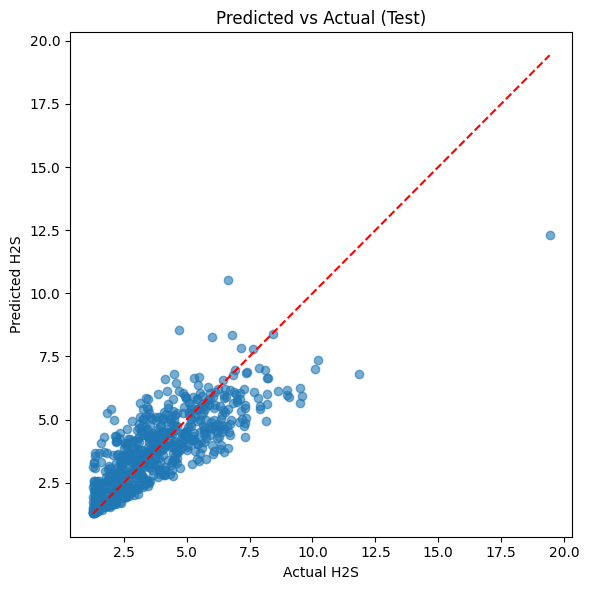

In [24]:
# 1) training history for best model (if saved history is not available, we skip)
plt.figure(figsize=(6,6))
plt.scatter(y_test_true, y_test_pred, alpha=0.6)
mn,mx = min(y_test_true.min(), y_test_pred.min()), max(y_test_true.max(), y_test_pred.max())
plt.plot([mn,mx],[mn,mx],'r--')
plt.xlabel("Actual H2S")
plt.ylabel("Predicted H2S")
plt.title("Predicted vs Actual (Test)")
plt.tight_layout()
plt.show()

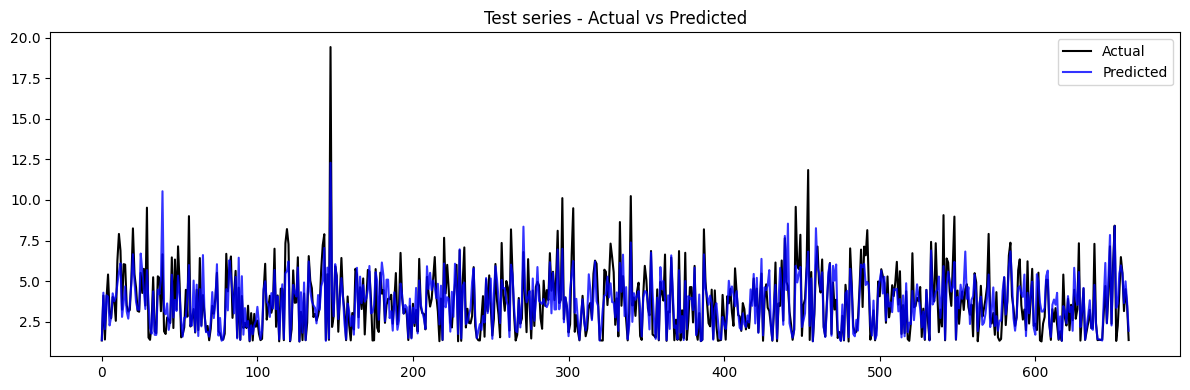

In [25]:
# 2) time-series like plot (index order, since shuffled split used)
plt.figure(figsize=(12,4))
plt.plot(y_test_true, label='Actual', color='black')
plt.plot(y_test_pred, label='Predicted', color='blue', alpha=0.8)
plt.legend()
plt.title("Test series - Actual vs Predicted")
plt.tight_layout()
plt.show()

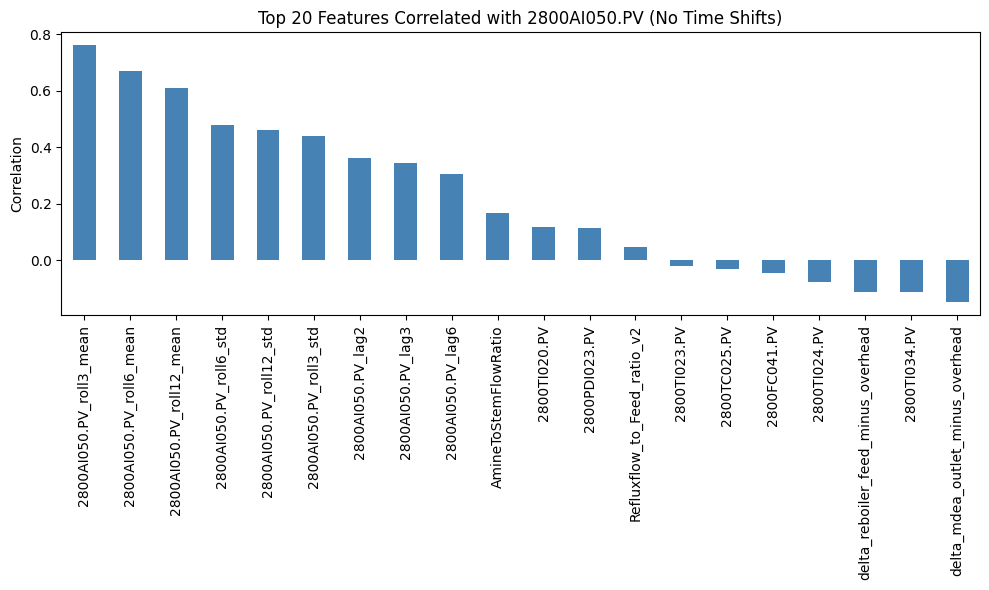

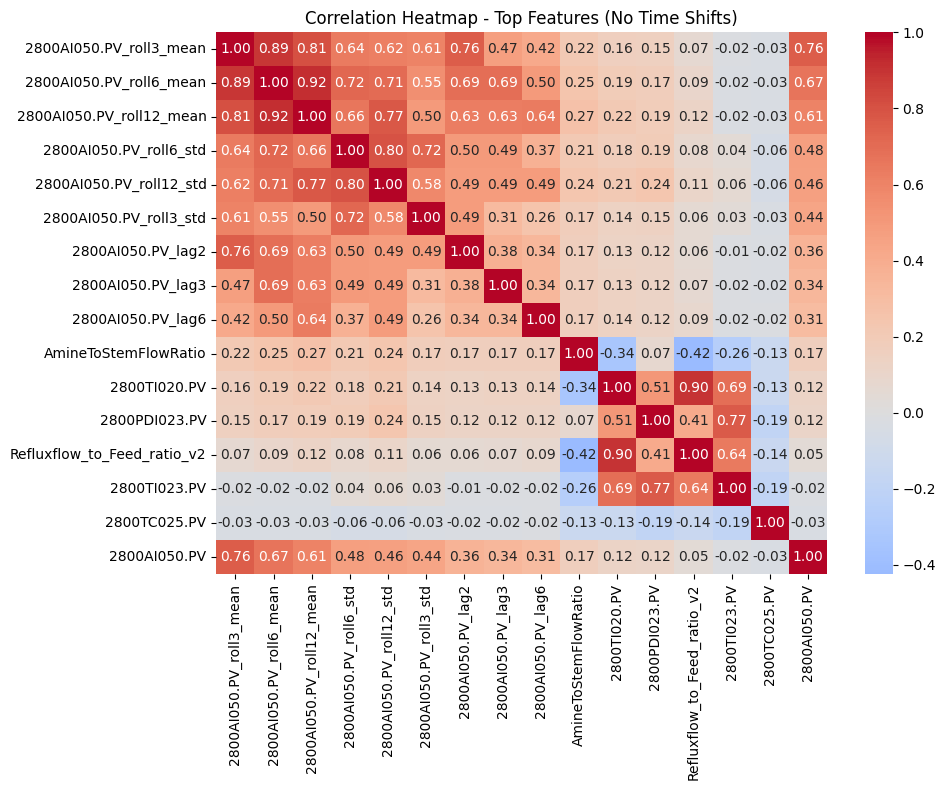

Top 15 correlated features with target (no time shifts):
2800AI050.PV_roll3_mean        0.761517
2800AI050.PV_roll6_mean        0.669044
2800AI050.PV_roll12_mean       0.610349
2800AI050.PV_roll6_std         0.477219
2800AI050.PV_roll12_std        0.461787
2800AI050.PV_roll3_std         0.441345
2800AI050.PV_lag2              0.362793
2800AI050.PV_lag3              0.342891
2800AI050.PV_lag6              0.306122
AmineToStemFlowRatio           0.167596
2800TI020.PV                   0.116740
2800PDI023.PV                  0.115683
Refluxflow_to_Feed_ratio_v2    0.046365
2800TI023.PV                  -0.021735
2800TC025.PV                  -0.030500
Name: 2800AI050.PV, dtype: float64


In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Ensure df is the original dataset without shifted columns
target = "2800AI050.PV"

# Select only numeric columns
df_num = df.select_dtypes(include=[np.number])

# Compute correlation matrix
corr_matrix = df_num.corr()

# Get correlation values with target, drop the target itself
target_corr = corr_matrix[target].drop(target).sort_values(ascending=False)

# Plot top 20 correlated features
plt.figure(figsize=(10,6))
target_corr.head(20).plot(kind='bar', color='steelblue')
plt.title(f"Top 20 Features Correlated with {target} (No Time Shifts)")
plt.ylabel("Correlation")
plt.tight_layout()
plt.show()

# Heatmap of top features
top_features = target_corr.head(15).index.tolist() + [target]
plt.figure(figsize=(10,8))
sns.heatmap(df_num[top_features].corr(), cmap="coolwarm", center=0, annot=True, fmt=".2f")
plt.title("Correlation Heatmap - Top Features (No Time Shifts)")
plt.tight_layout()
plt.show()

# Print top 15 correlations as table
print("Top 15 correlated features with target (no time shifts):")
print(target_corr.head(15))


In [29]:
# Save model in the new Keras format
model.save("H2S_ANN_Model.keras")

print("✅ Model saved in native Keras format (H2S_ANN_Model.keras)")


✅ Model saved in native Keras format (H2S_ANN_Model.keras)
